In [1]:
import gzip
import TeledyneLeCroyPy
from matplotlib import pyplot as plt
import requests
import numpy as np
import time
import pandas as pd
import h5py
import pickle
import json
import os
import pandas as pd
import gspread
from google.oauth2 import service_account
import json

credentials = service_account.Credentials.from_service_account_file(
    '../.google_credentials.json')
scope = ['https://spreadsheets.google.com/feeds']
creds_scope = credentials.with_scopes(scope)
client = gspread.authorize(creds_scope)

sheet = client.open_by_key('1idBnsYG4pHdHZ2kDbq-S3PBUAf0ewFEzKXOtCTGDxyU')
log = sheet.worksheet("log")


def read_pickle_file(filename):
    try:
        with open(filename, 'rb') as file:
            data = pickle.load(file)
        return data
    except FileNotFoundError:
        print(f"File '{filename}' not found.")
        return None
    except pickle.UnpicklingError as e:
        print(f"Error occurred while unpickling '{filename}': {e}")
        return None

def plot_waveform(x,y):
    from matplotlib import pyplot as plt
    import numpy as np

    x = x*1e9
    y = y/1e-3
    plt.plot(x,y)
    plt.xlabel('ns')
    plt.ylabel('mV')


def read_hdf5(filename):
    data = {}
    with h5py.File(filename, 'r') as hdf_file:
        # Iterate over the groups in the HDF5 file
        for group_name in hdf_file:
            group = hdf_file[group_name]
            group_data = {}
            # Iterate over the datasets in each group
            for dataset_name in group:
                dataset = group[dataset_name]
                # Check if the dataset is scalar
                # print(dataset)
                if isinstance(dataset, h5py.Dataset) and dataset.shape == ():
                    # Read the value from the scalar dataset
                    group_data[dataset_name] = dataset[()]
                else:
                    # For non-scalar datasets, read the entire dataset
                    group_data[dataset_name] = dataset[:]
            # Add group data to the main data dictionary
            data[group_name] = group_data
    return data

# Nome del file HDF5 compresso con gzip
filename = '/Volumes/WC/data/run_00017.h5.gz'
def read_hdf5_gz(filename):
    with gzip.open(filename, 'rb') as f:
        print('file open')
        # Aprire il file HDF5 decompresso
        data = read_hdf5(f)
    return data



def time_fft(x,y, col, label):
#    fig, ax = plt.subplots(1,2, figsize=(10,4))
    ax[0].plot(x,y, col, label=label)
    ax[0].grid()
    ax[0].legend()

    signalFFT = np.fft.rfft(y)
    signalPSD = np.abs(signalFFT) ** 2
    fftFreq = np.fft.fftfreq(len(signalPSD))
    i = fftFreq>0
    A = 10*np.log10(signalPSD[i])
    ax[1].plot(fftFreq[i], A, col, label=label)
    ax[1].grid()
    ax[1].set_xlim(0,0.1)
    ax[1].legend()
    #plt.show()


ModuleNotFoundError: No module named 'TeledyneLeCroyPy'

file open
0


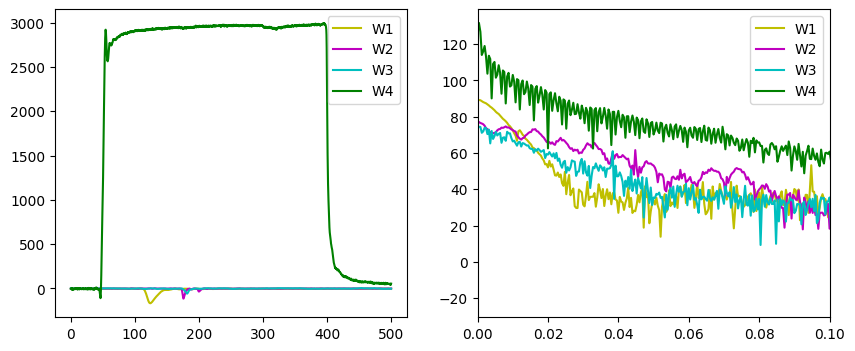

1


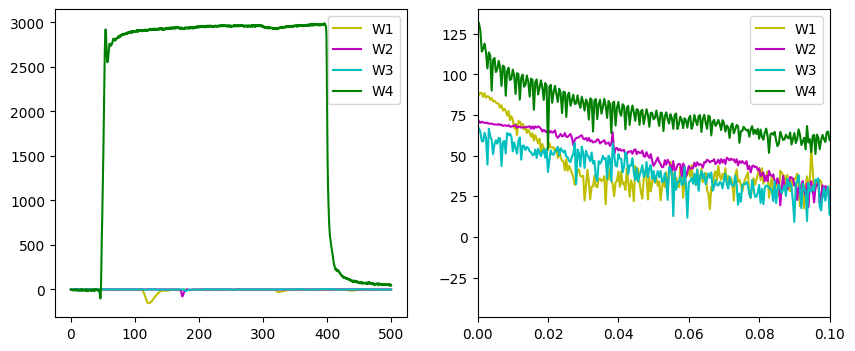

2


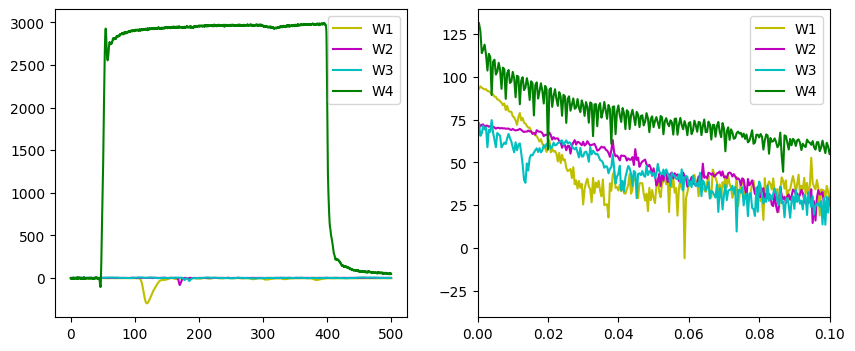

3


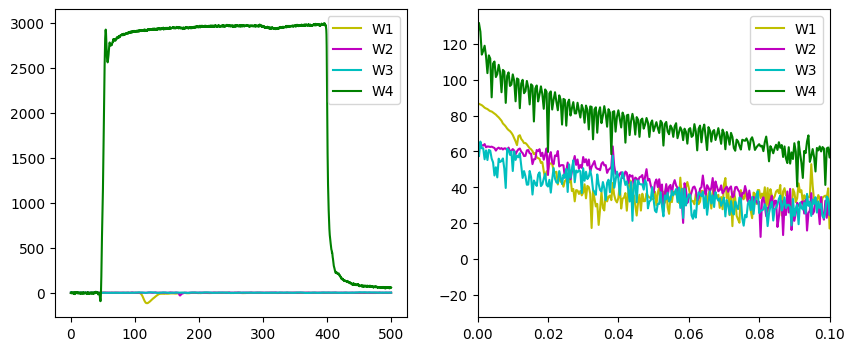

4


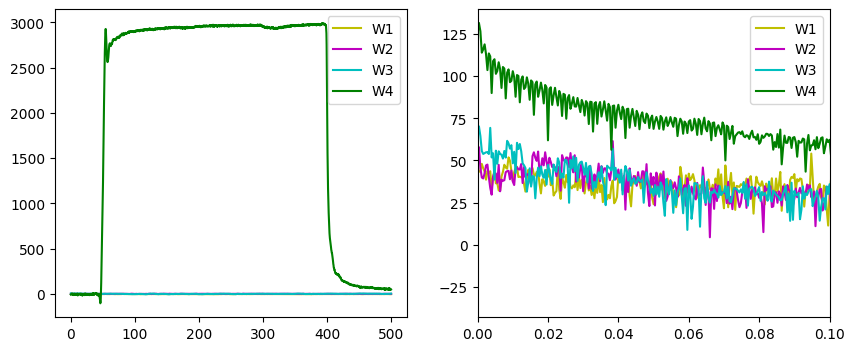

5


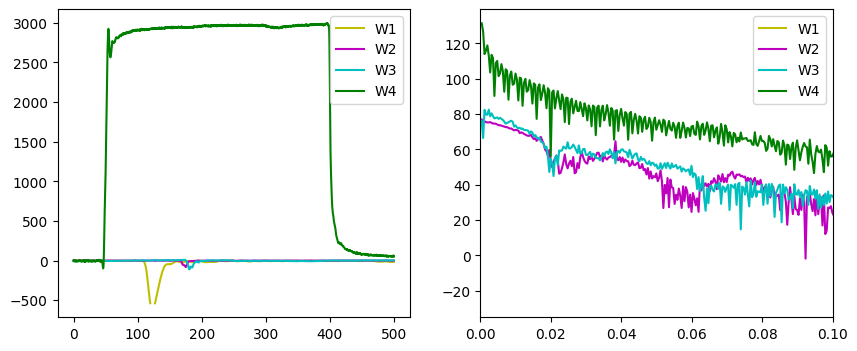

6


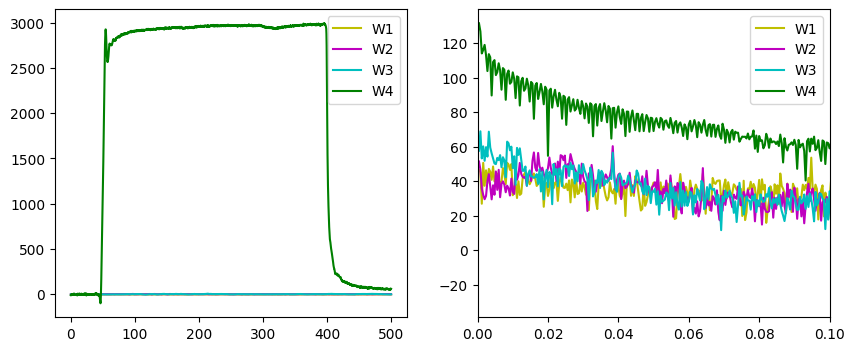

7


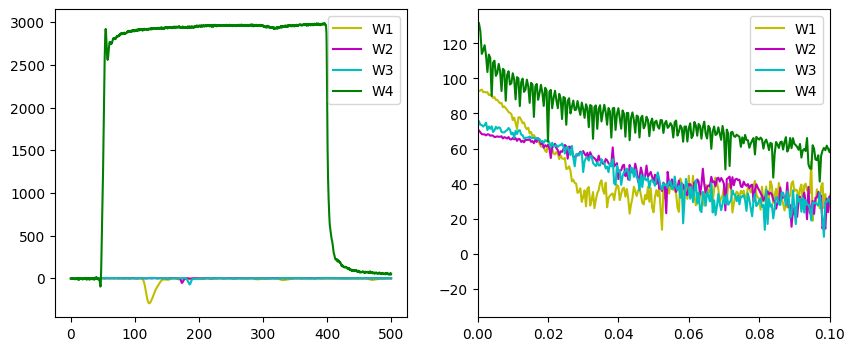

8


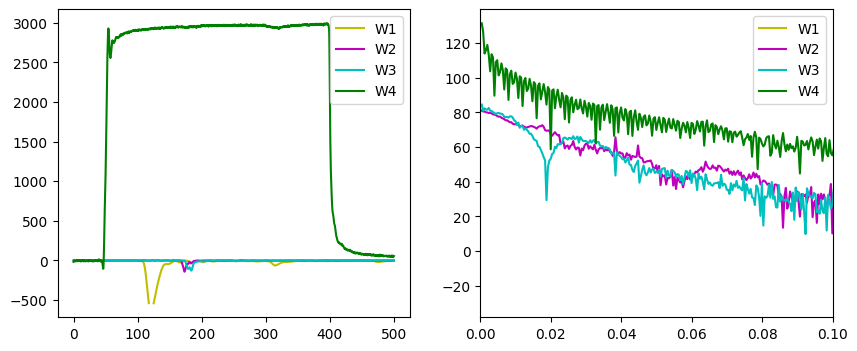

9


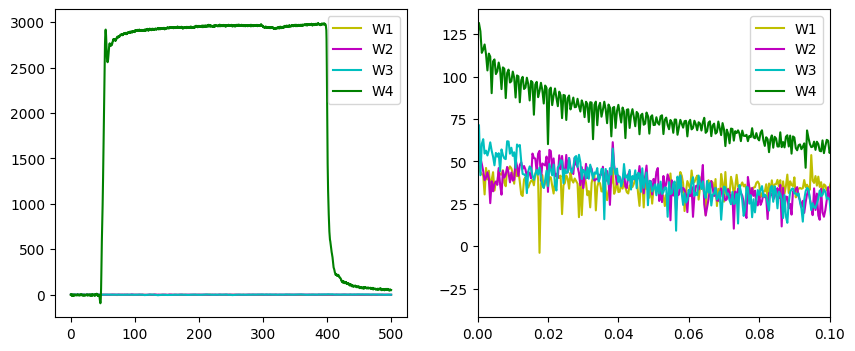

10


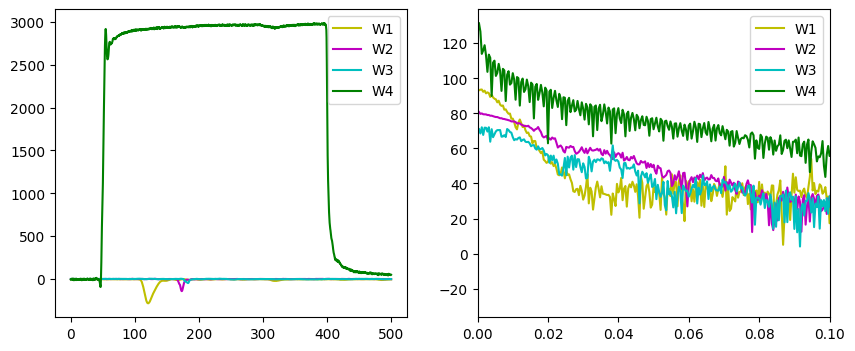

11


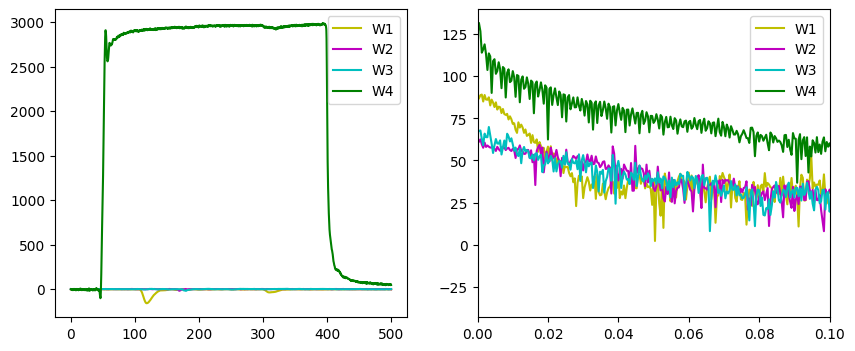

12


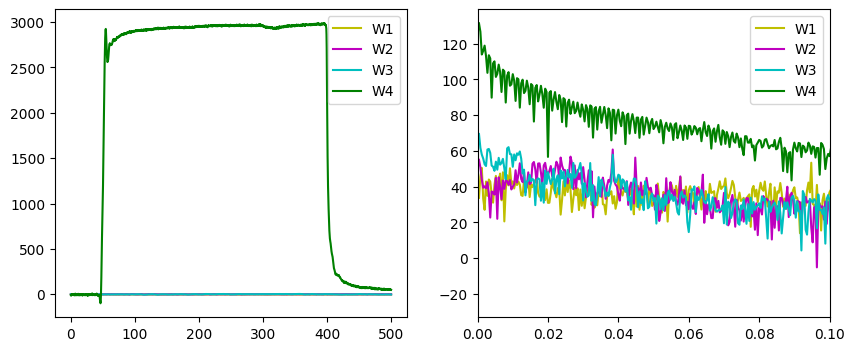

13


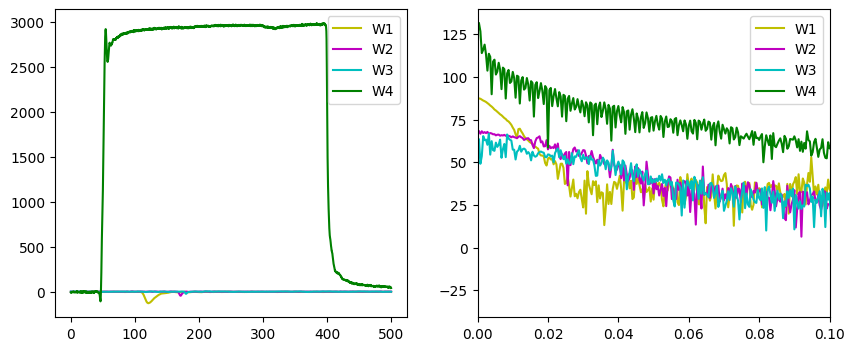

14


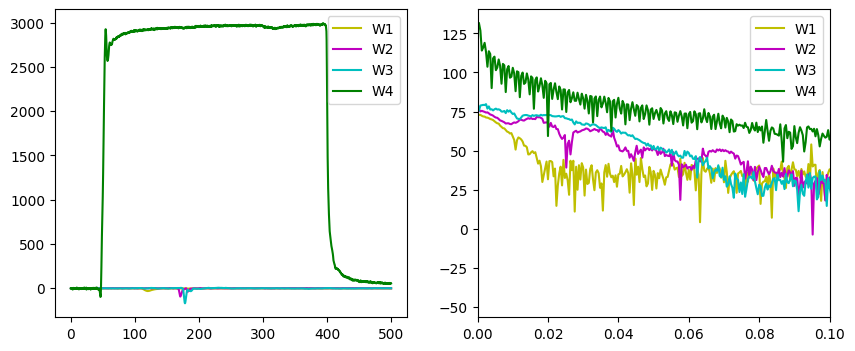

15


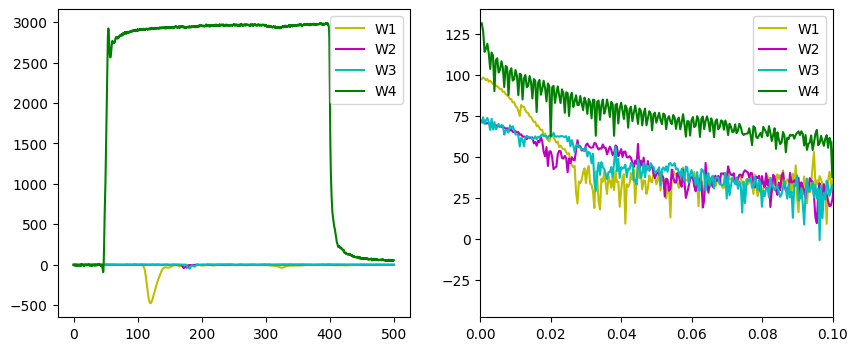

16


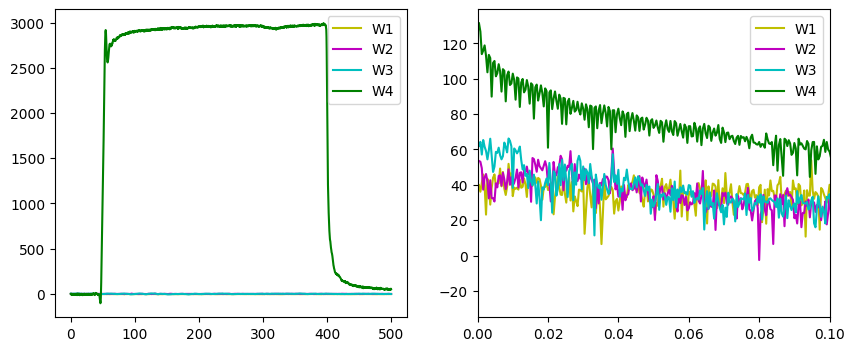

17


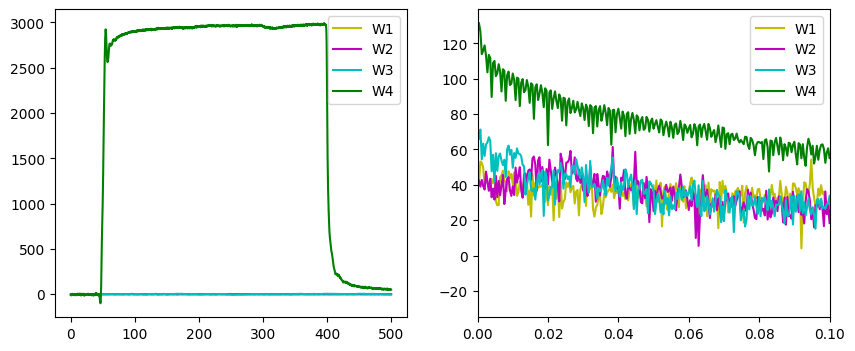

18


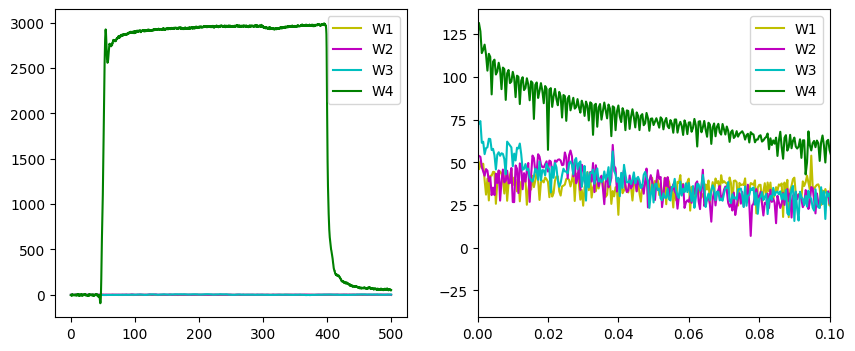

19


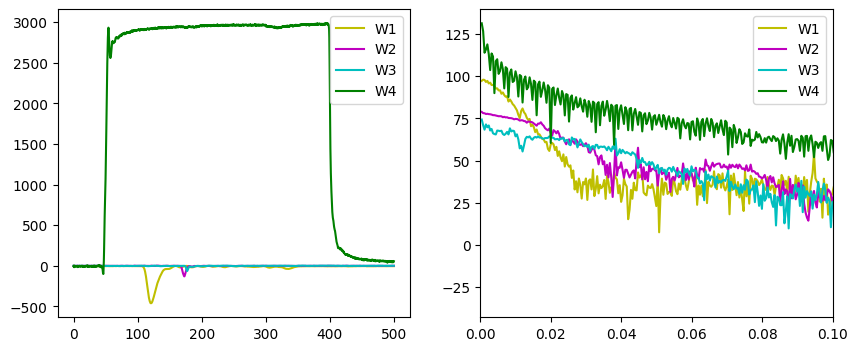

20


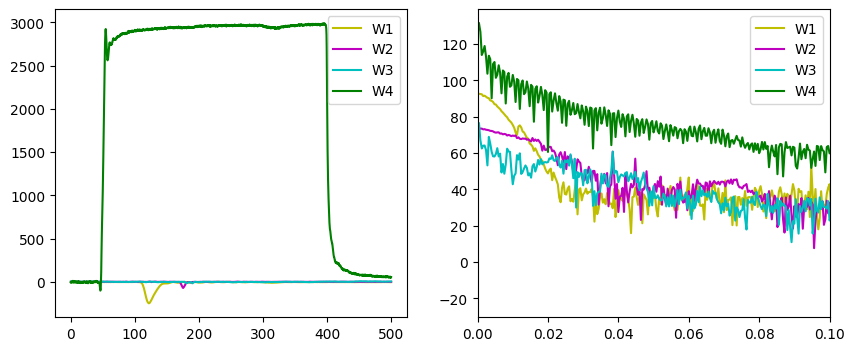

21


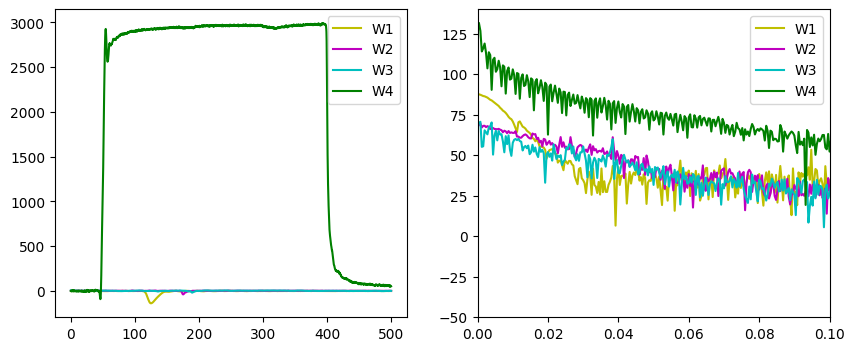

22


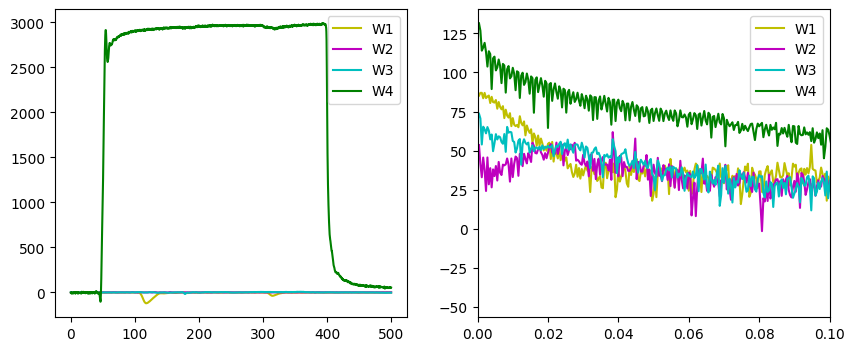

23


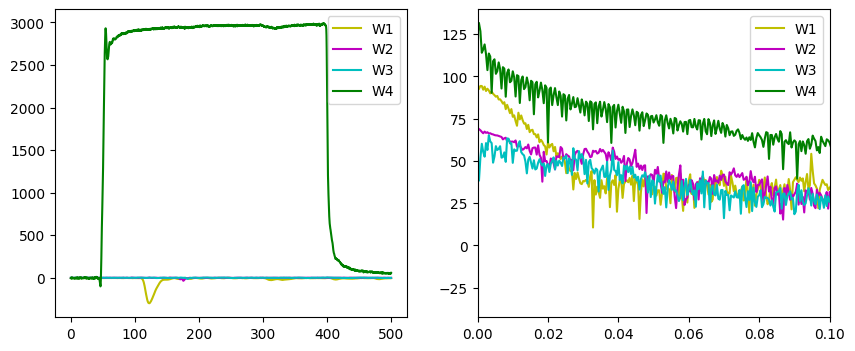

24


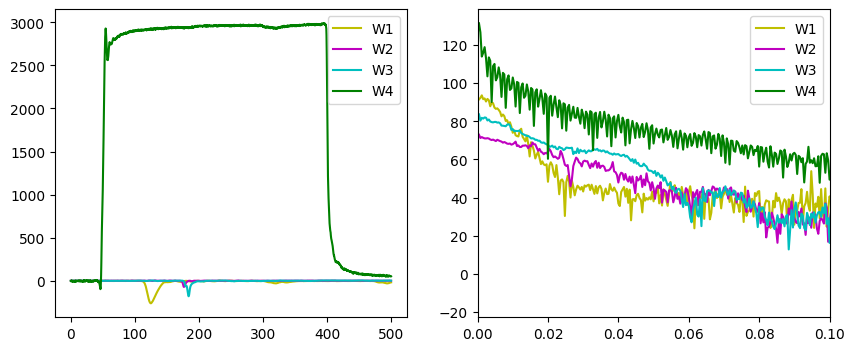

25


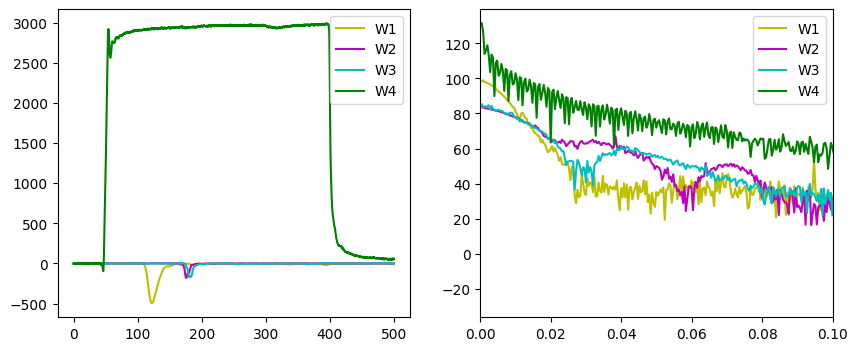

26


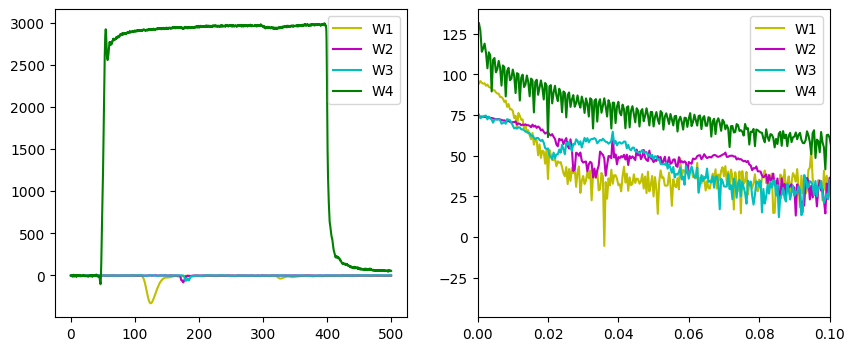

27


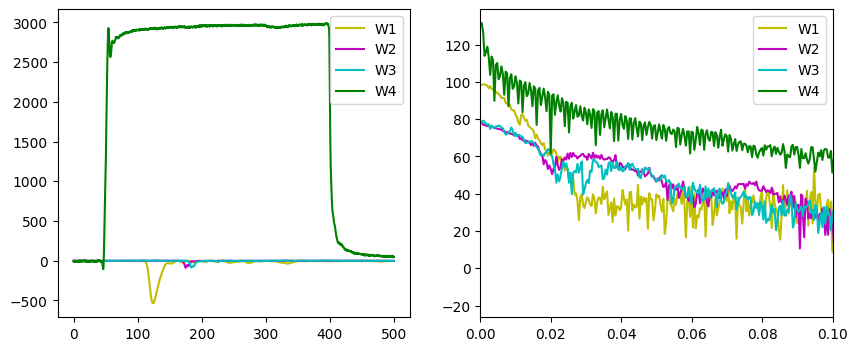

28


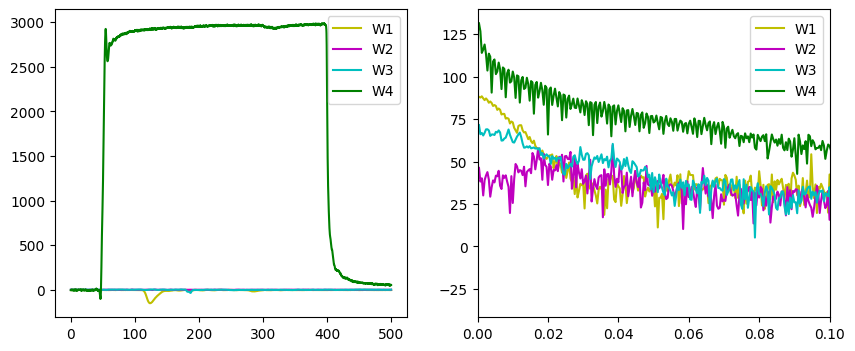

29


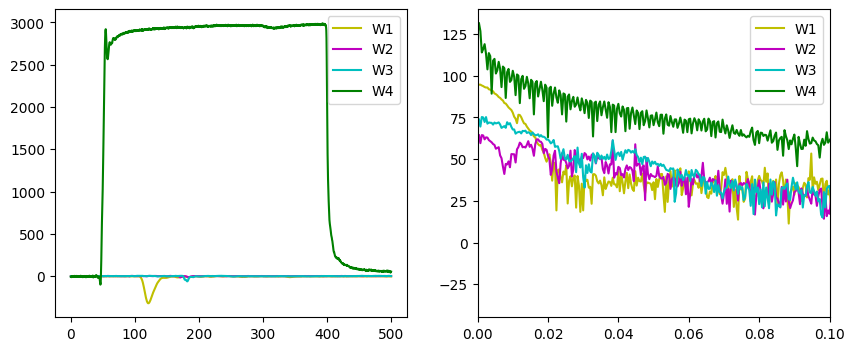

30


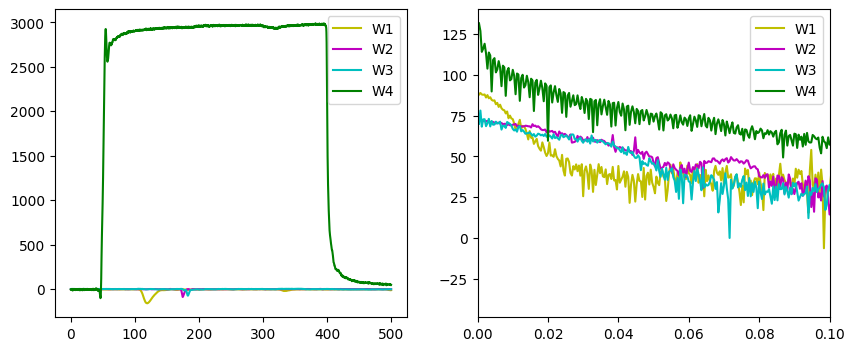

31


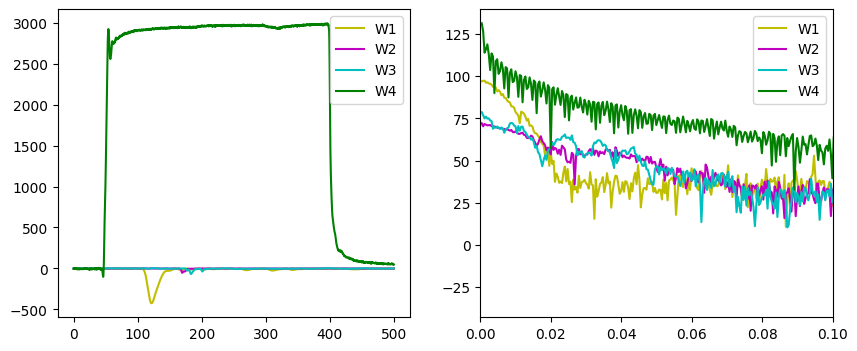

32


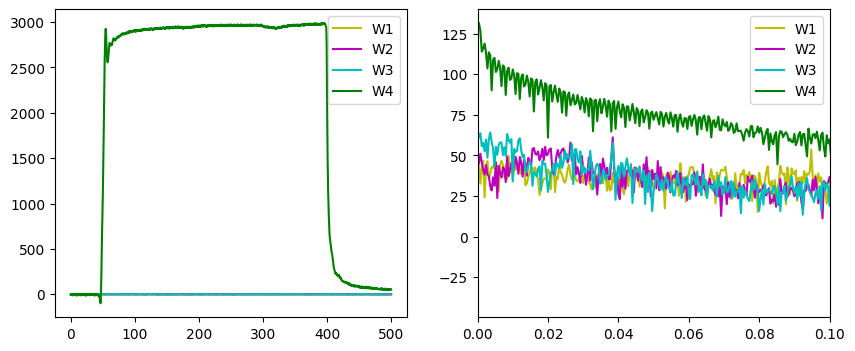

33


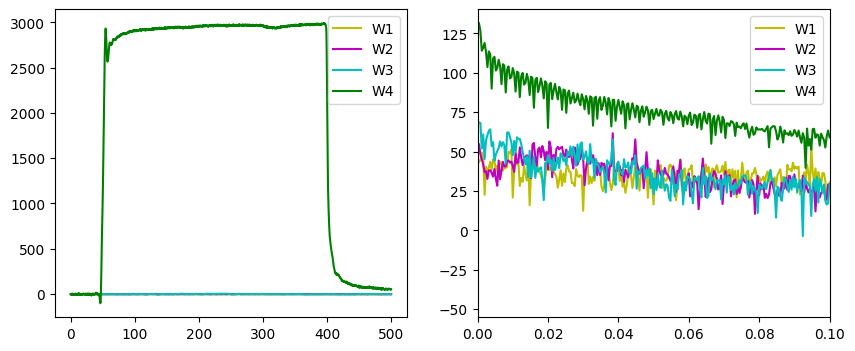

34


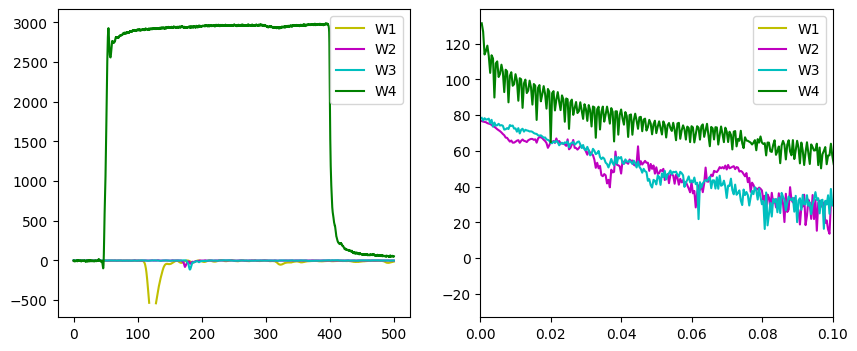

35


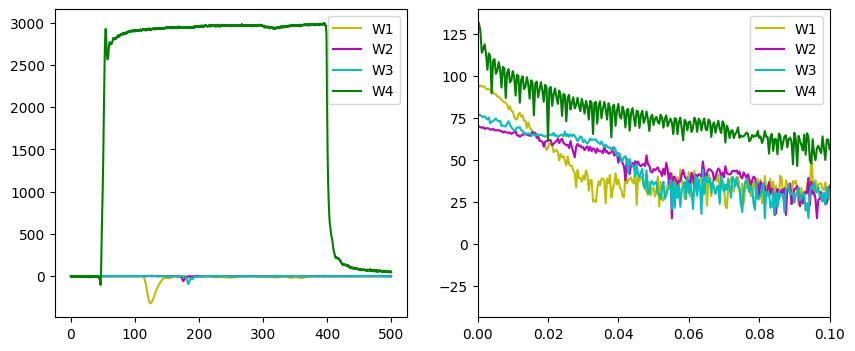

36


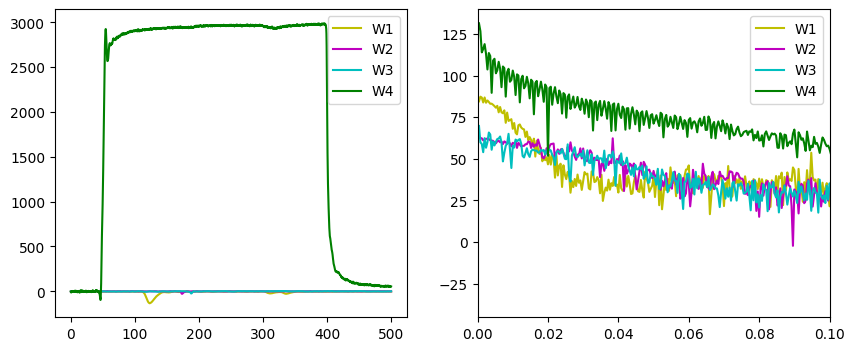

37


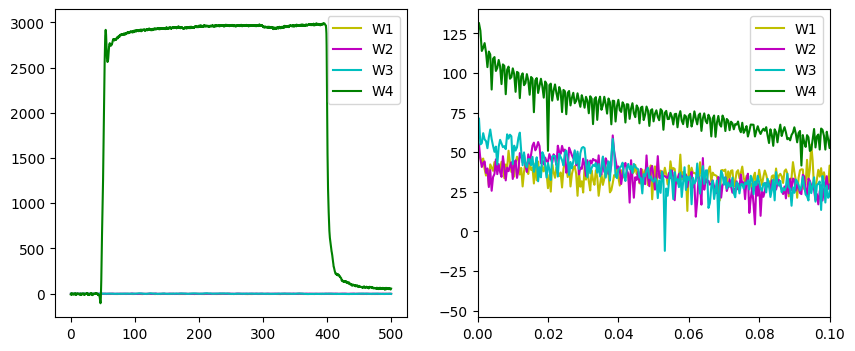

38


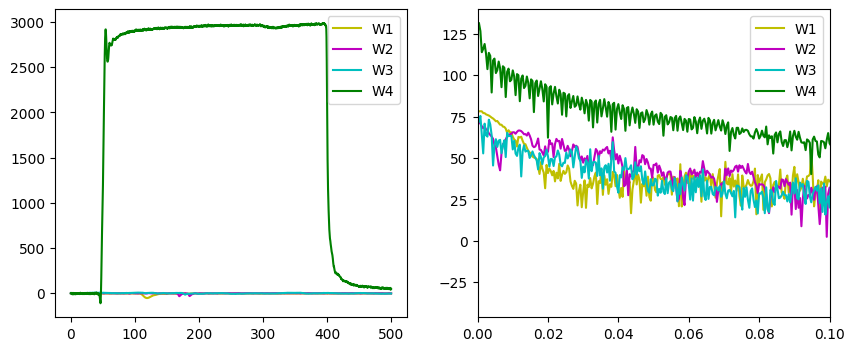

39


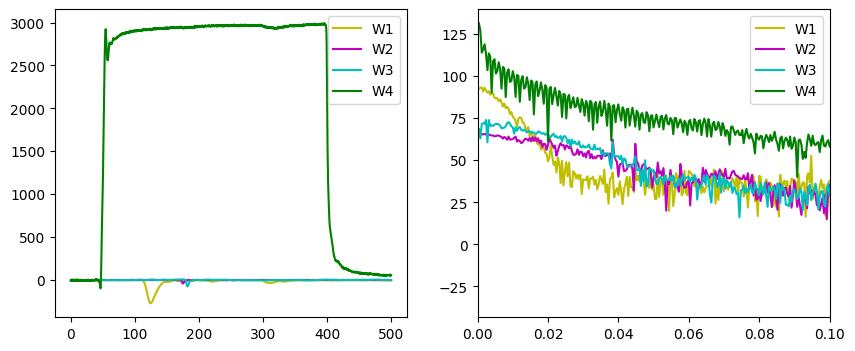

40


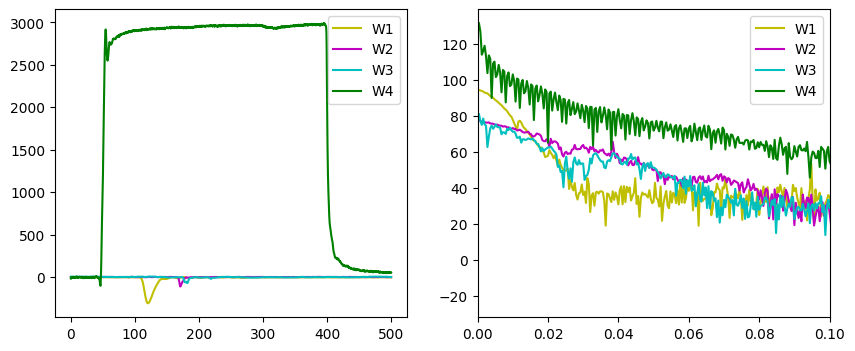

41


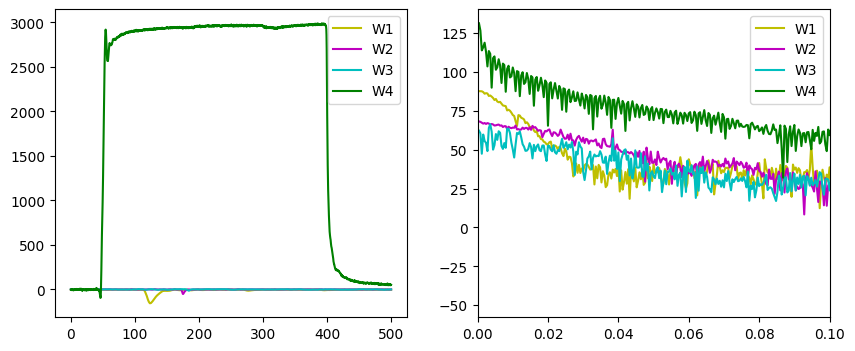

42


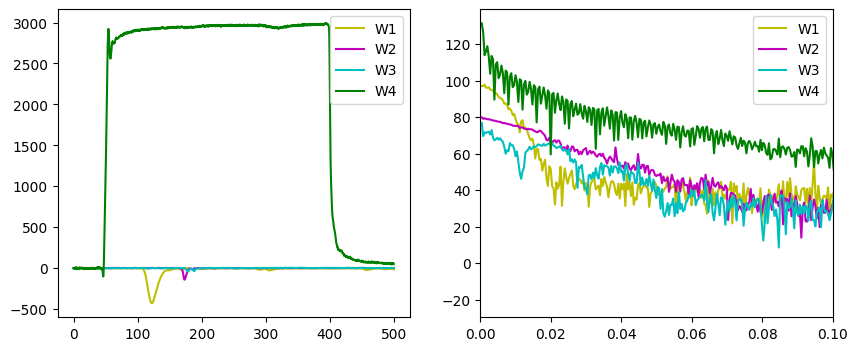

43


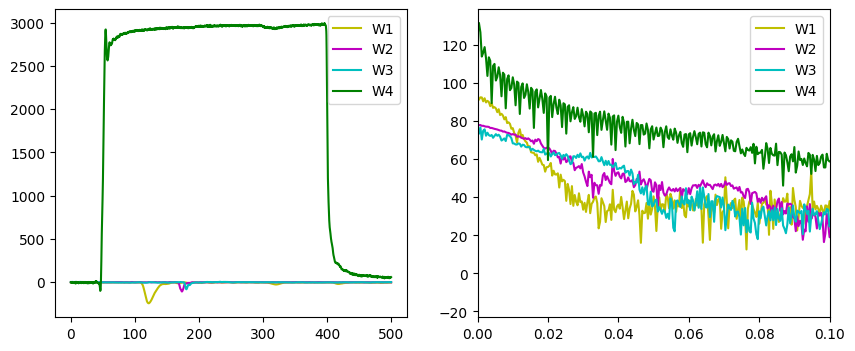

44


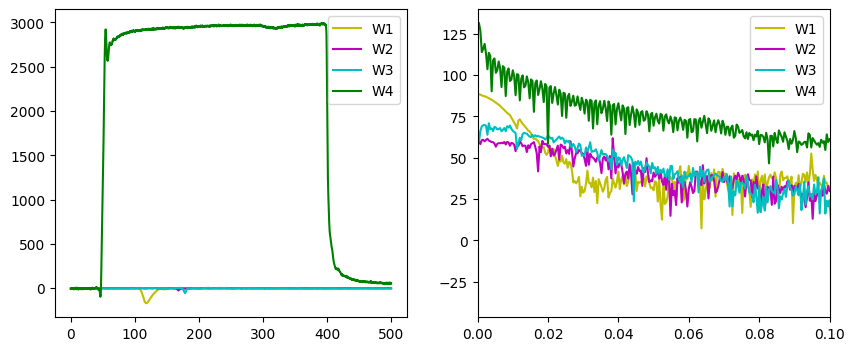

45


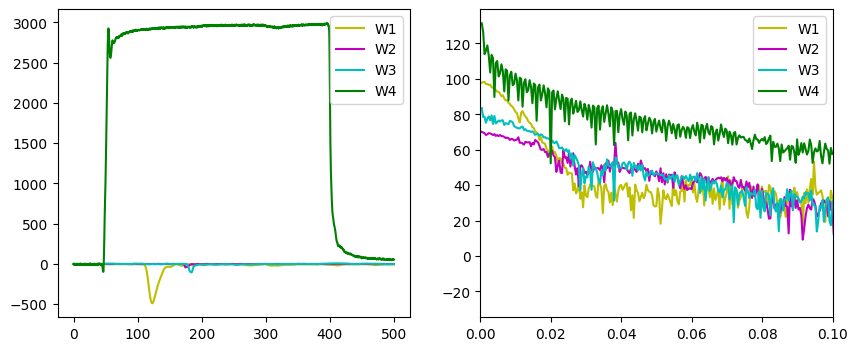

46


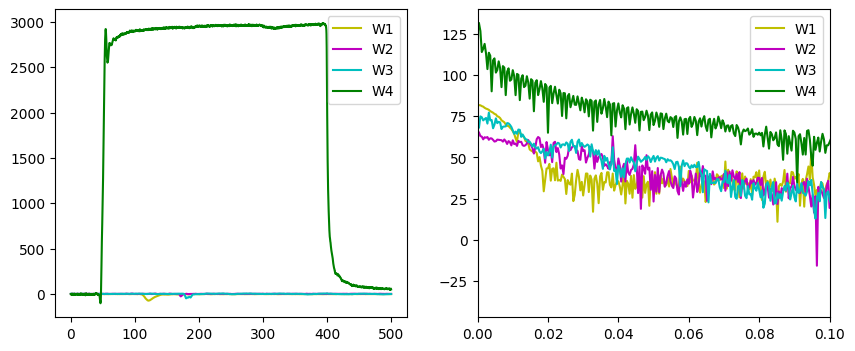

47


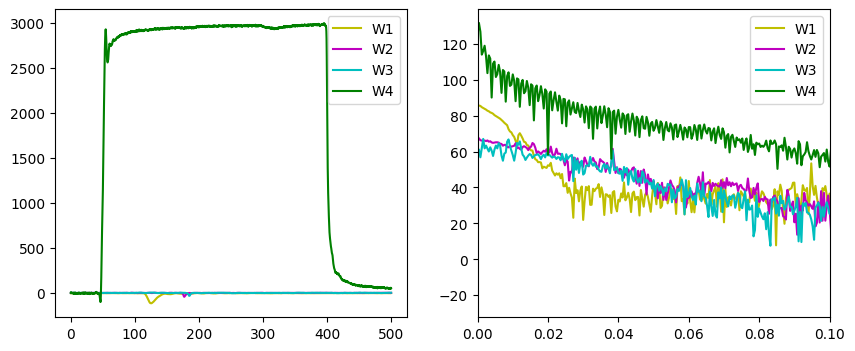

48


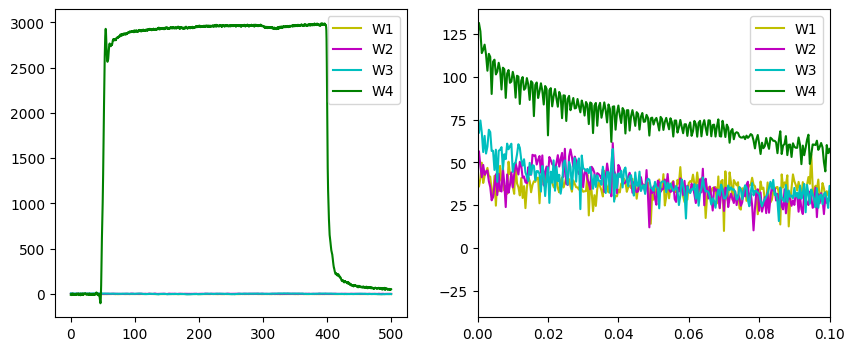

49


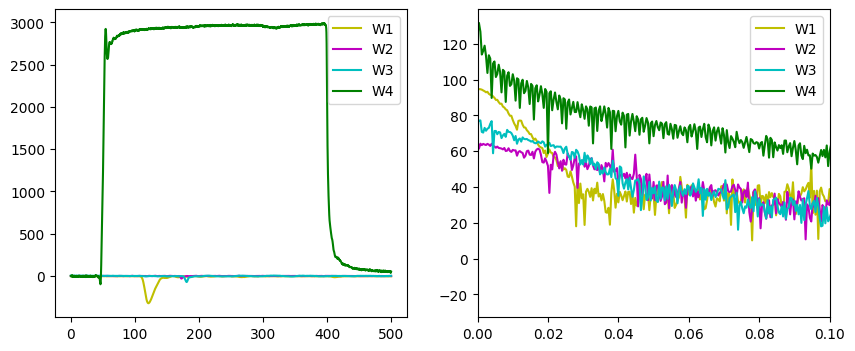

50


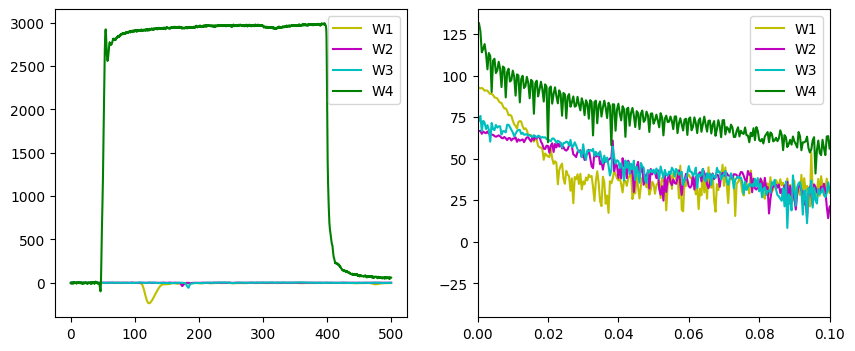

51


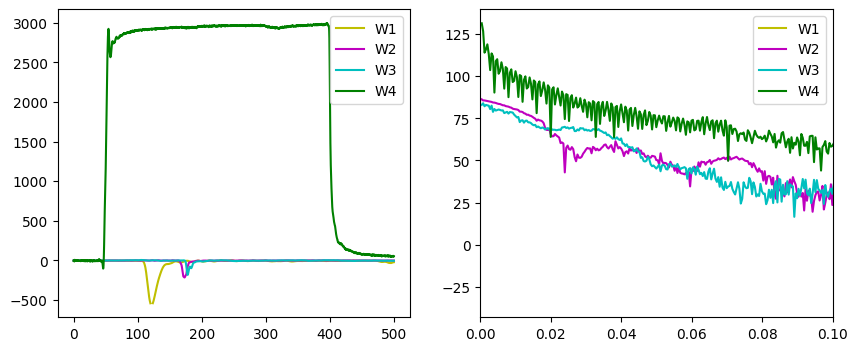

52


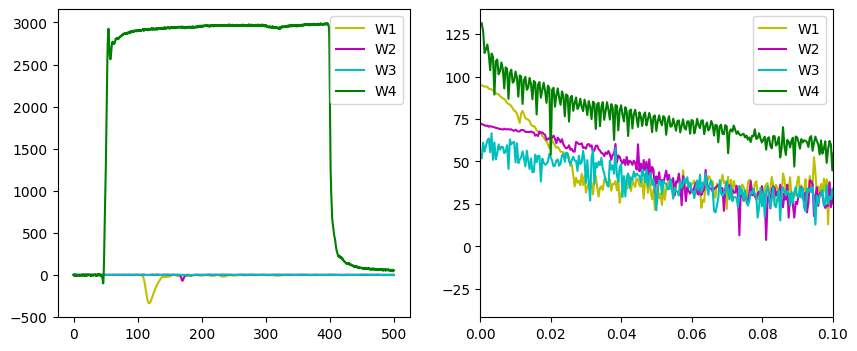

53


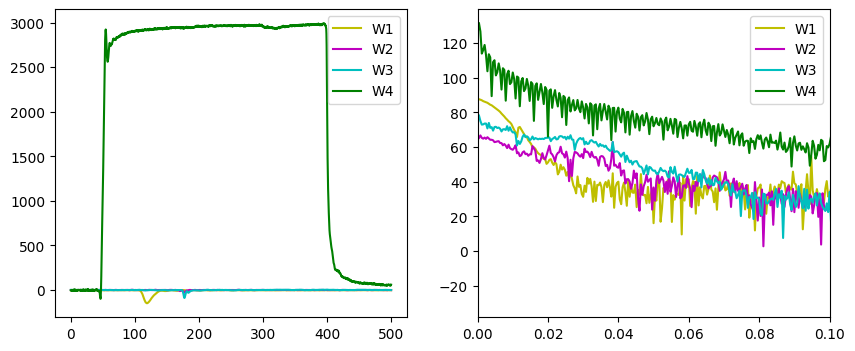

54


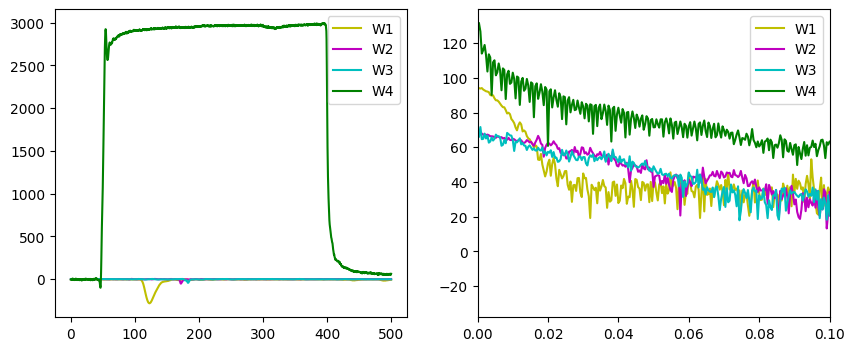

55


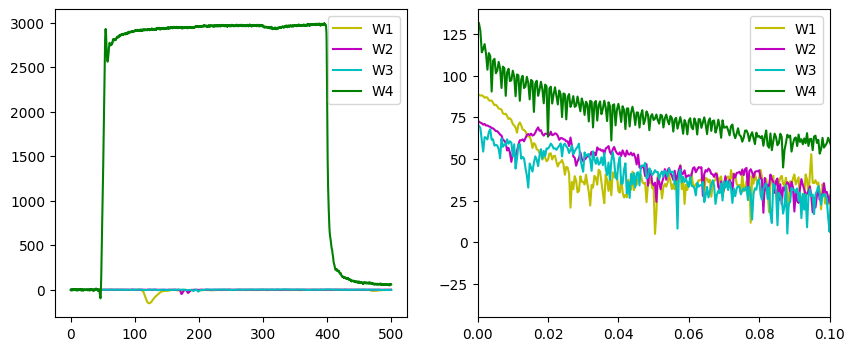

56


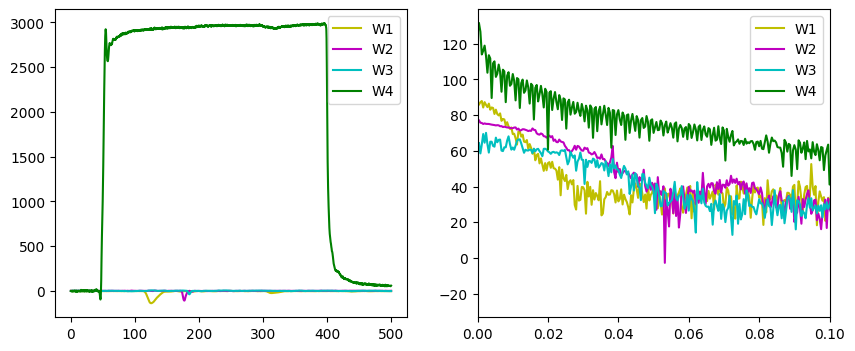

57


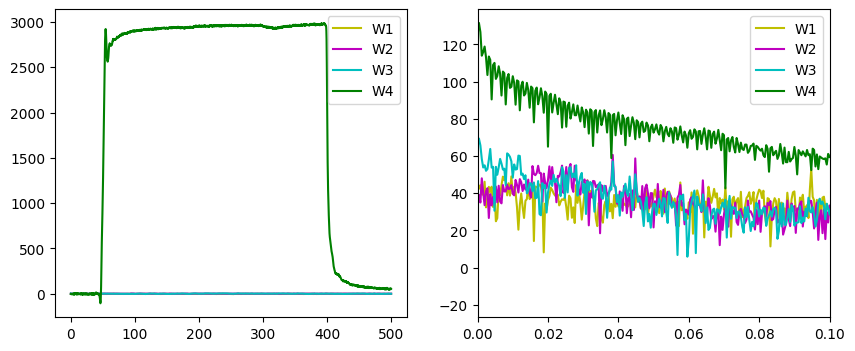

58


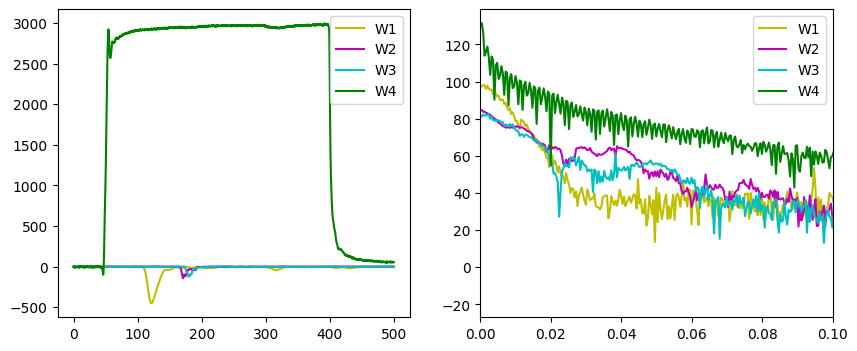

59


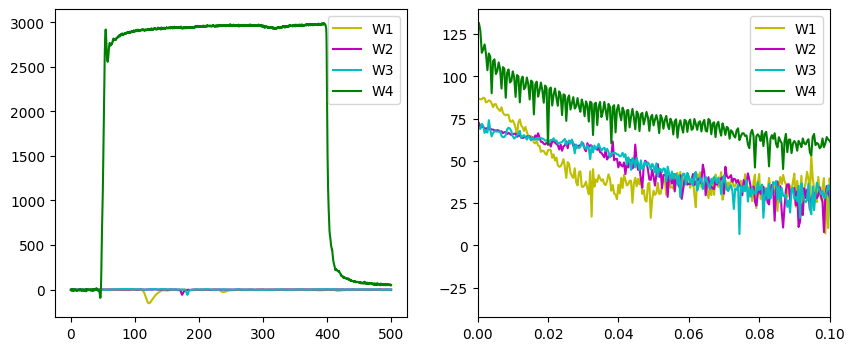

60


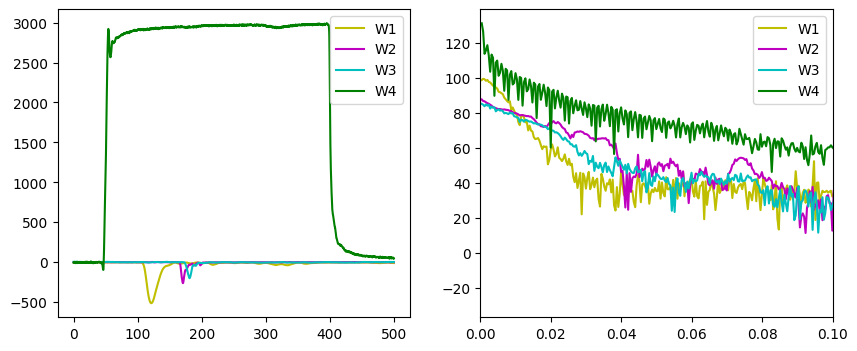

61


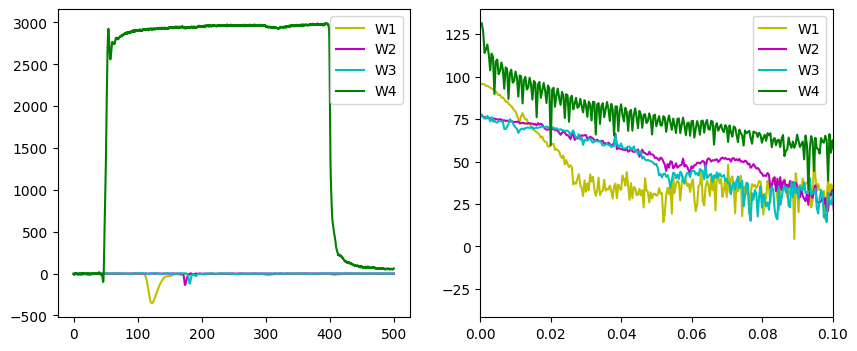

62


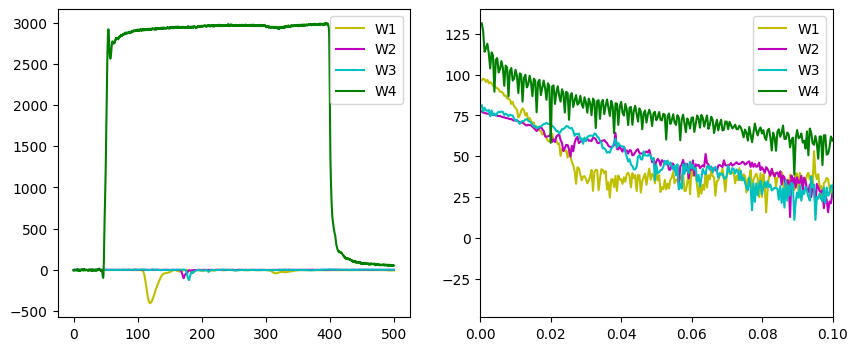

63


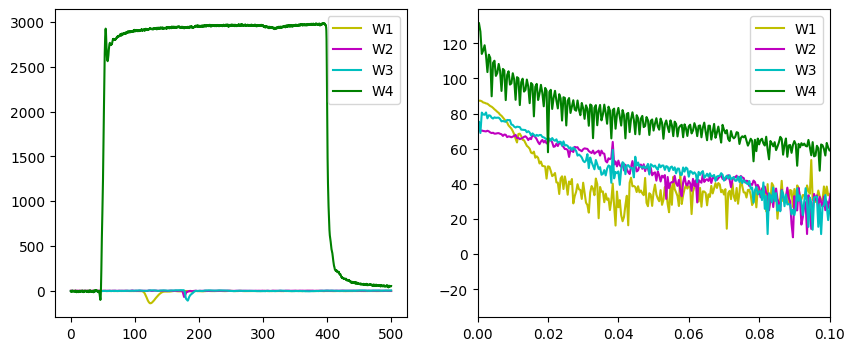

64


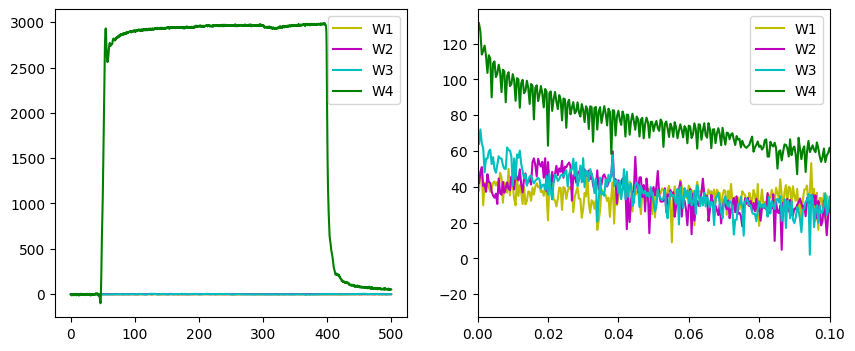

65


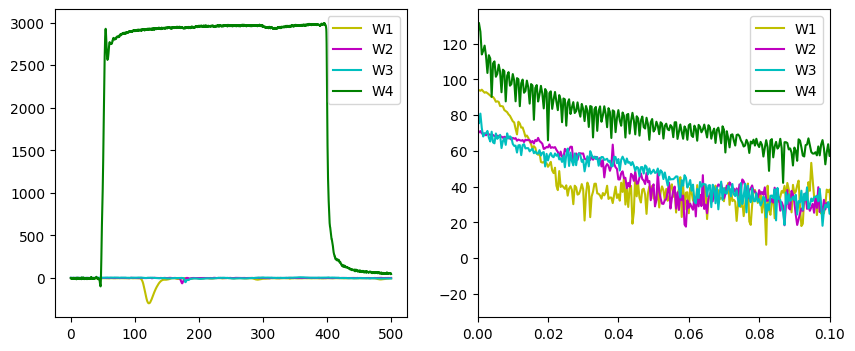

66


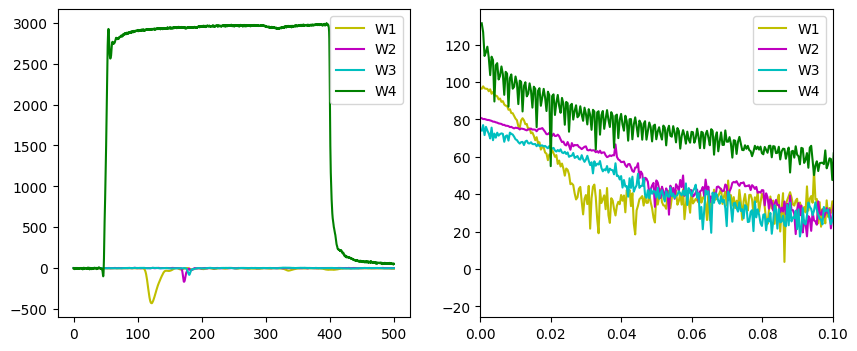

67


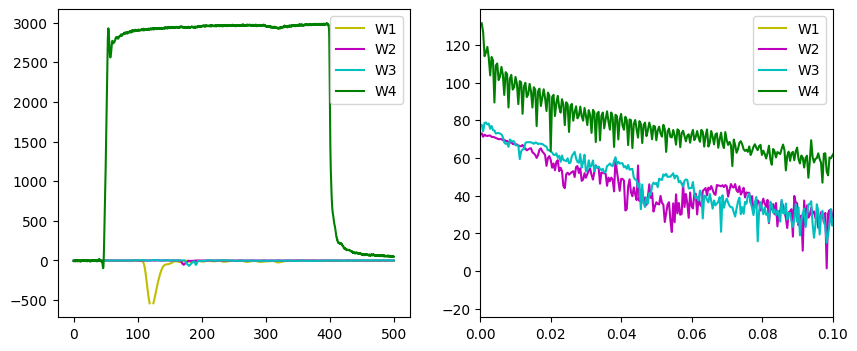

68


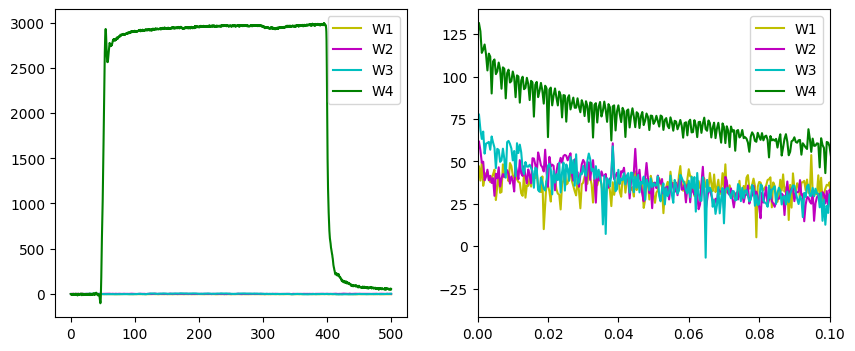

69


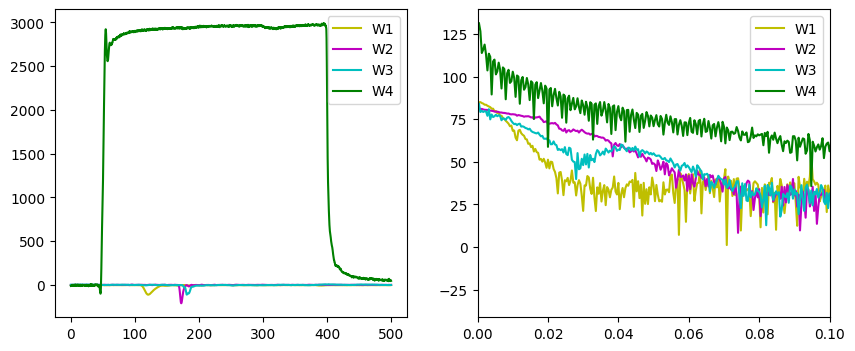

70


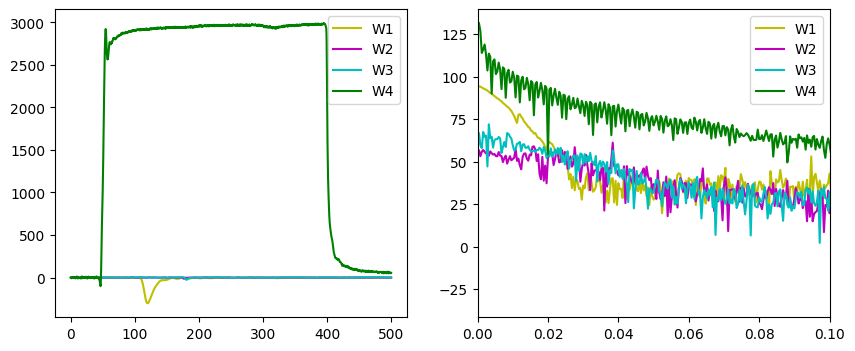

71


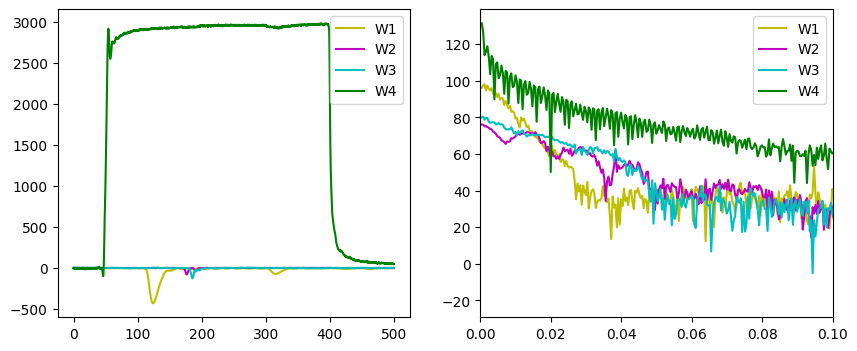

72


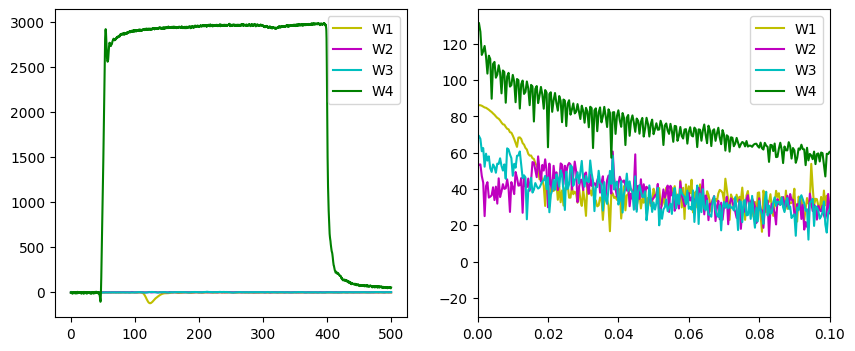

73


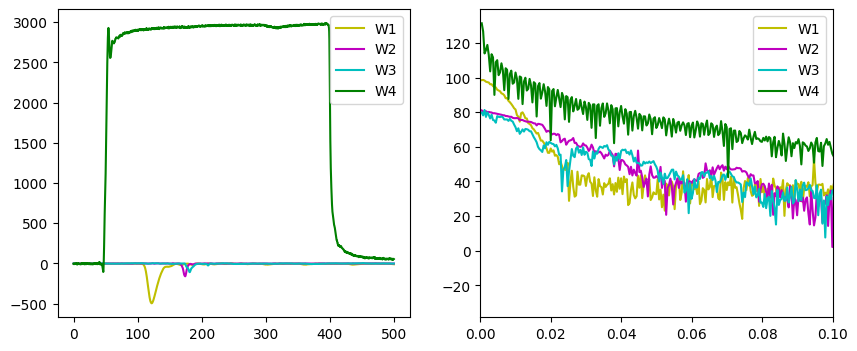

74


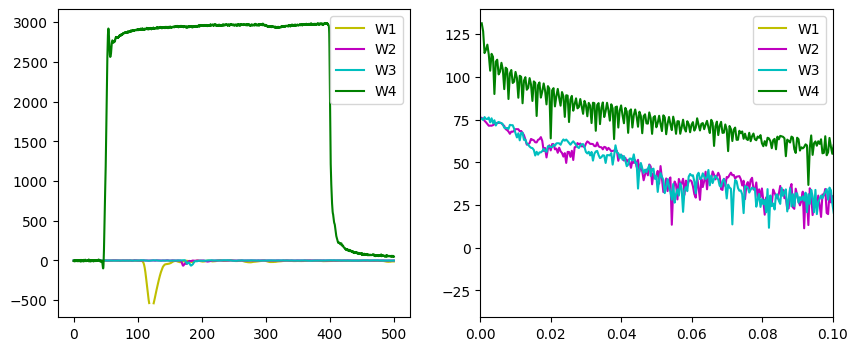

75


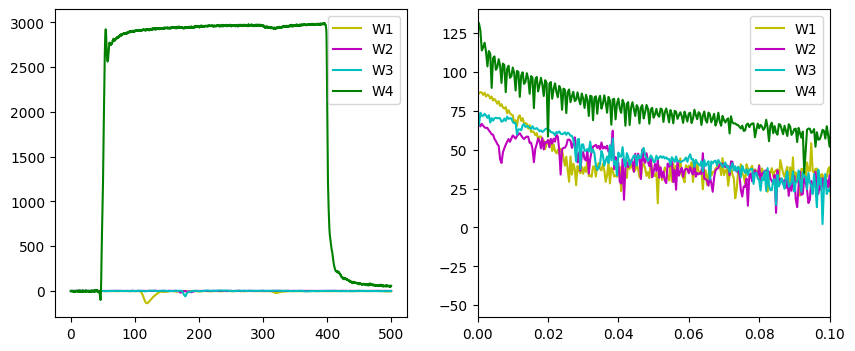

76


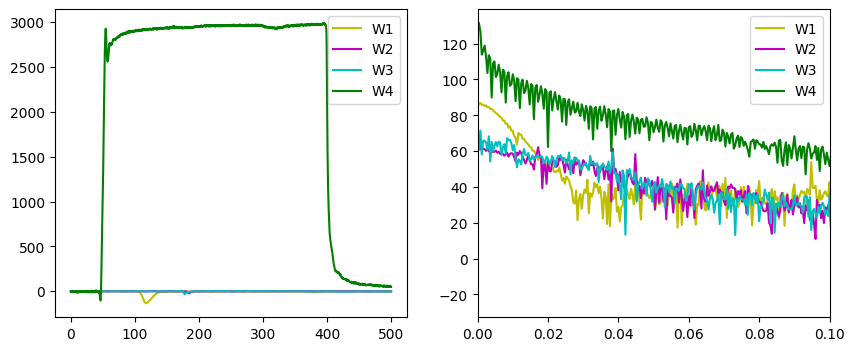

77


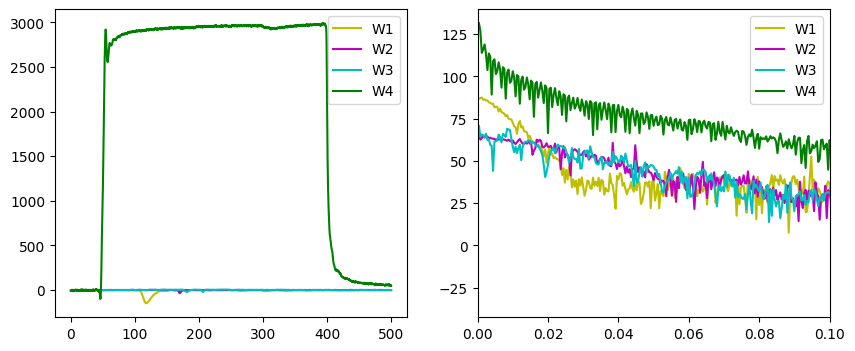

78


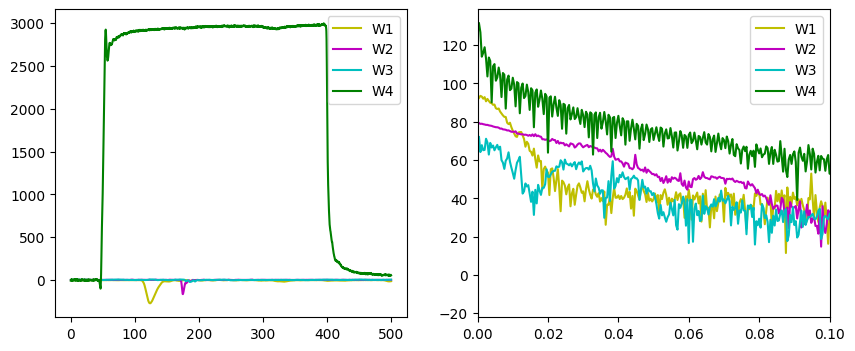

79


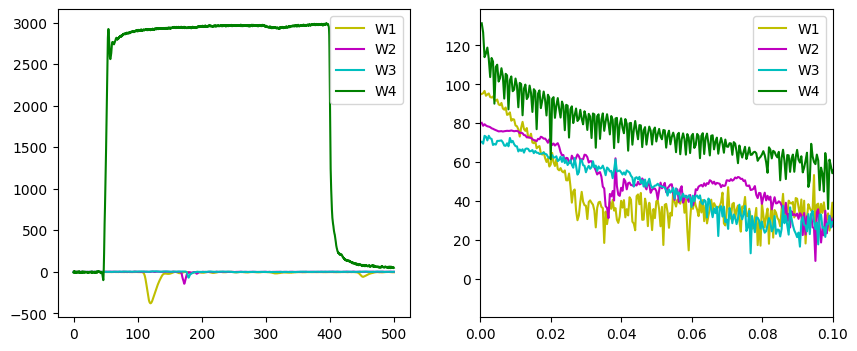

80


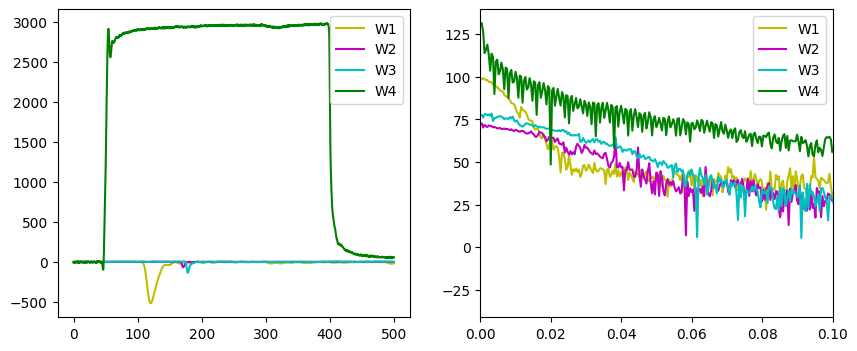

81


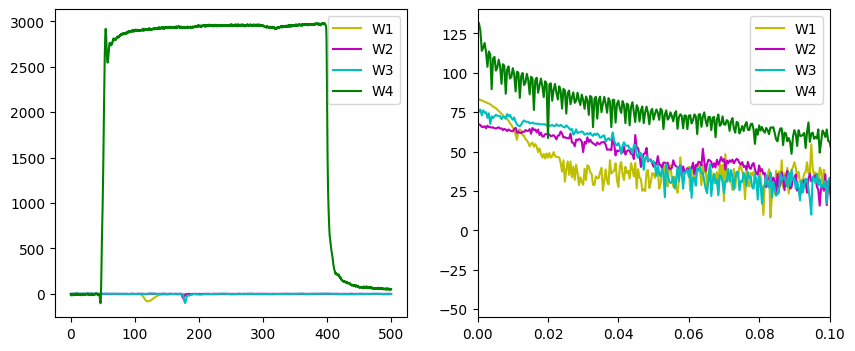

82


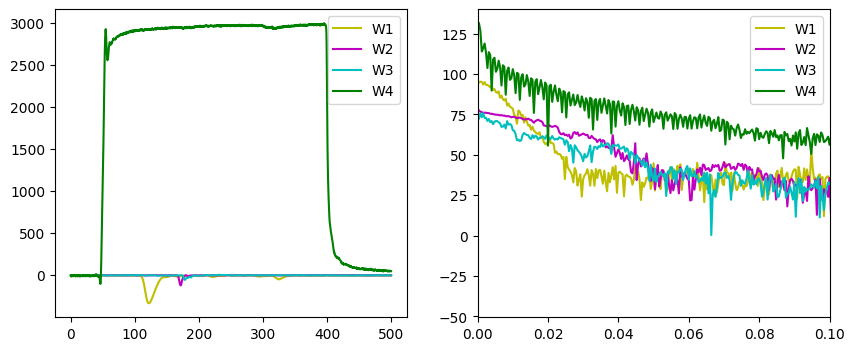

83


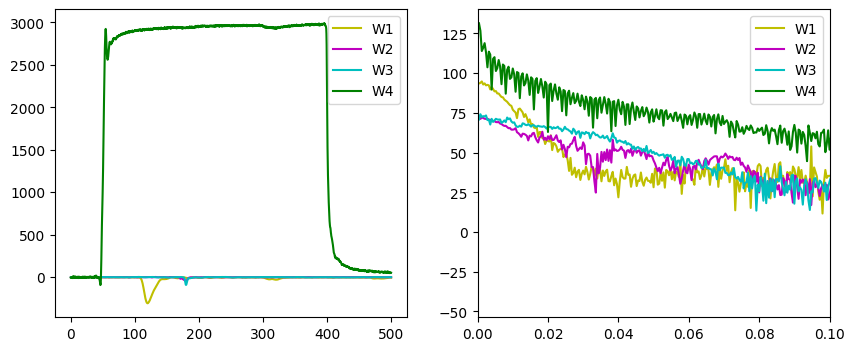

84


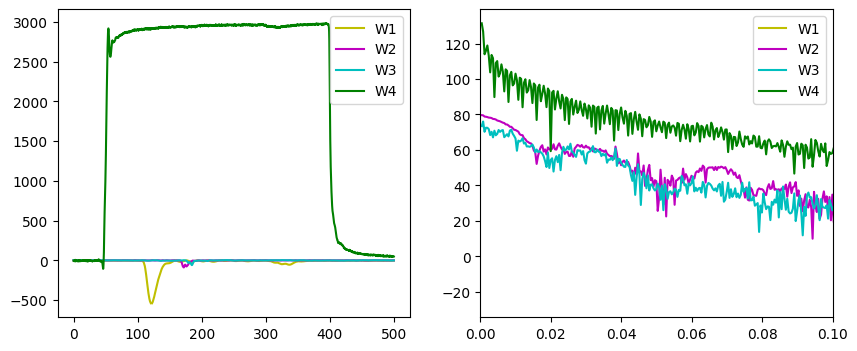

85


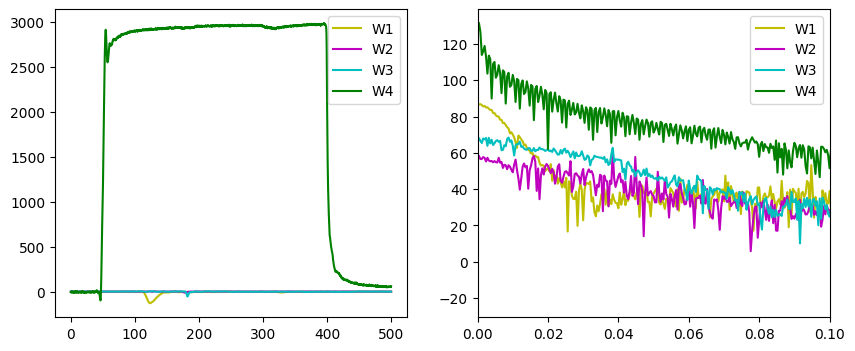

86


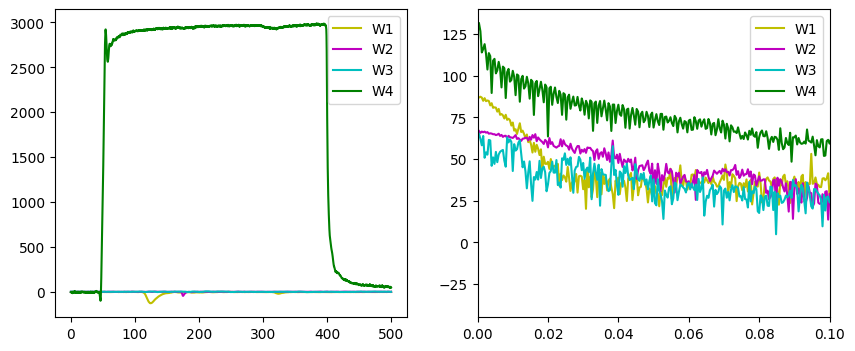

87


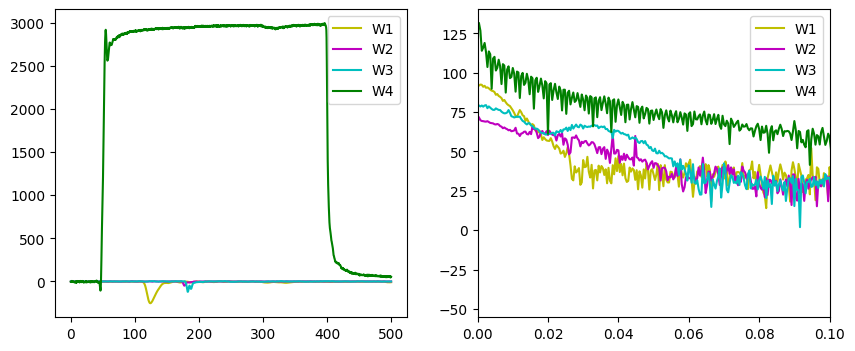

88


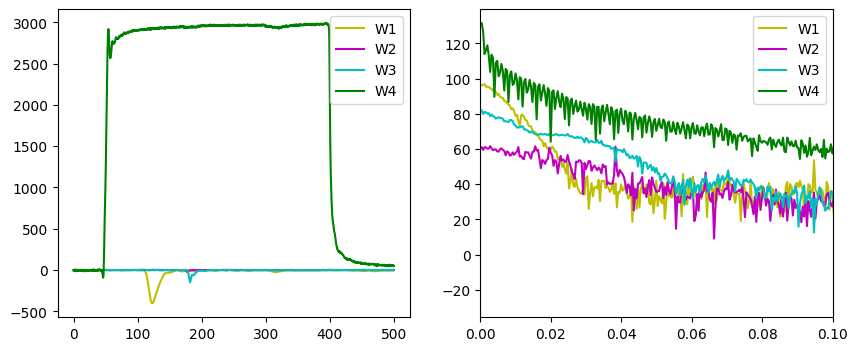

89


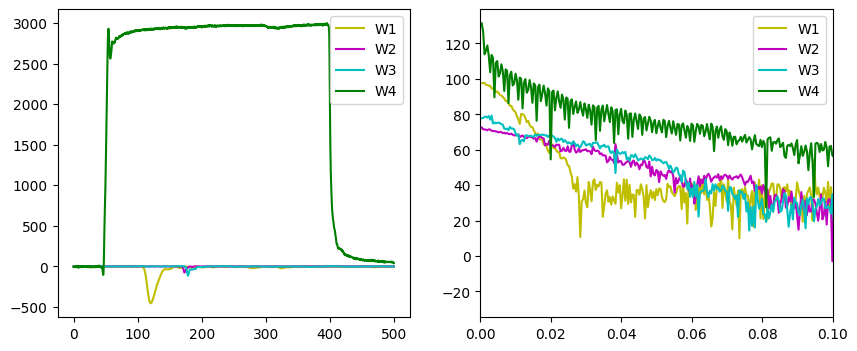

90


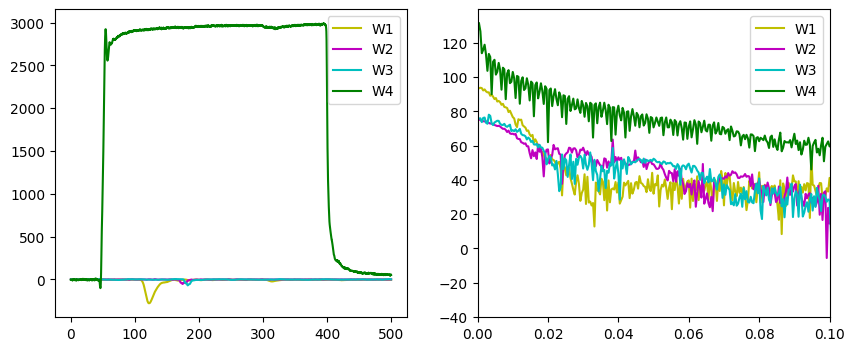

91


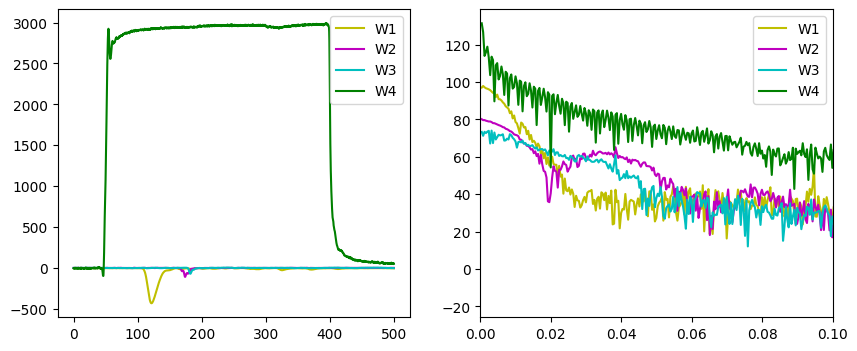

92


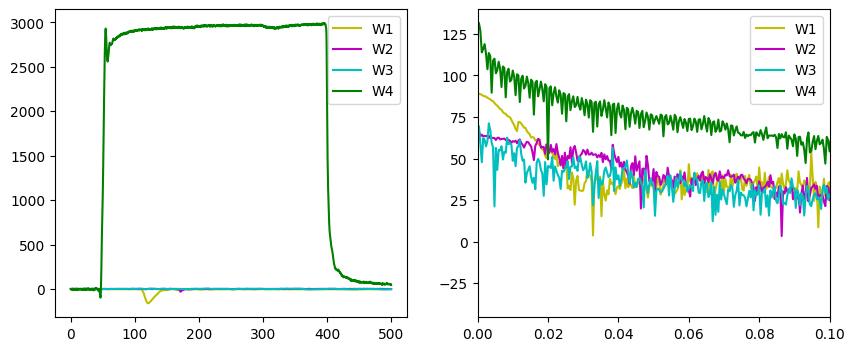

93


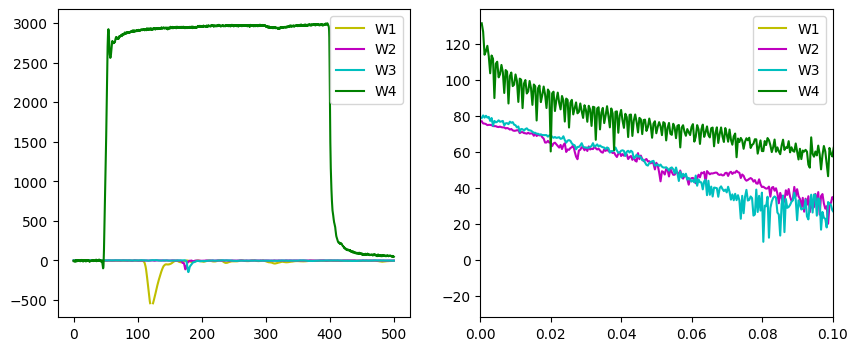

94


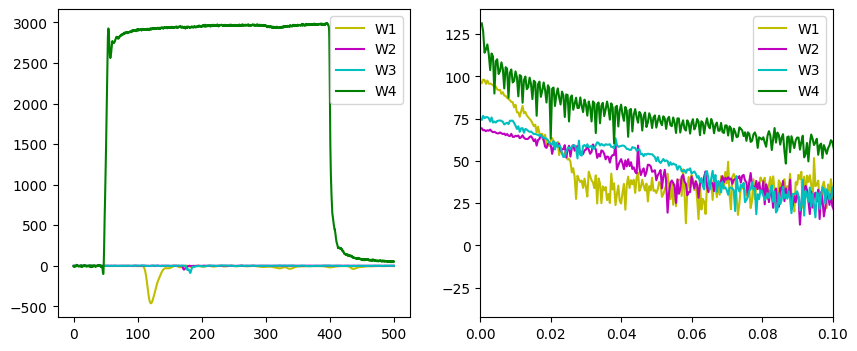

95


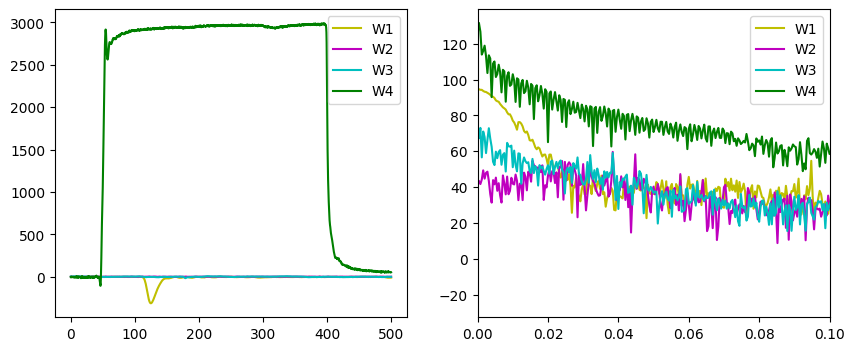

96


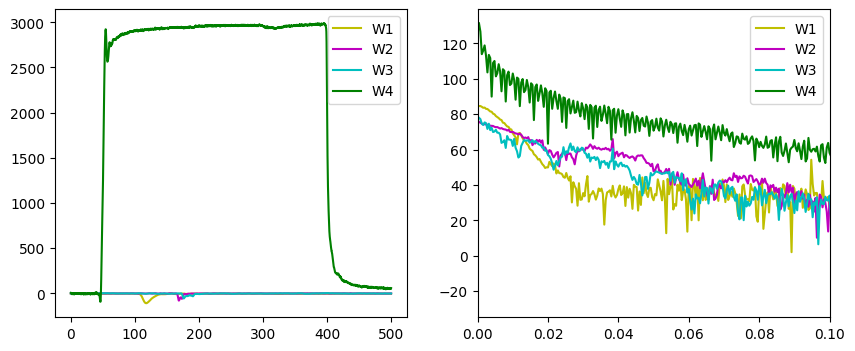

97


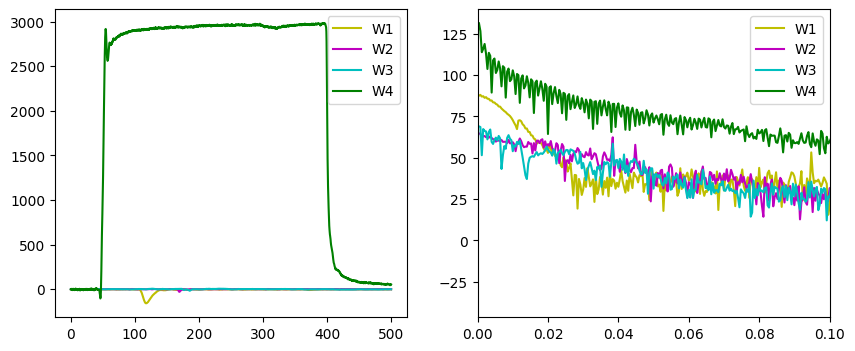

98


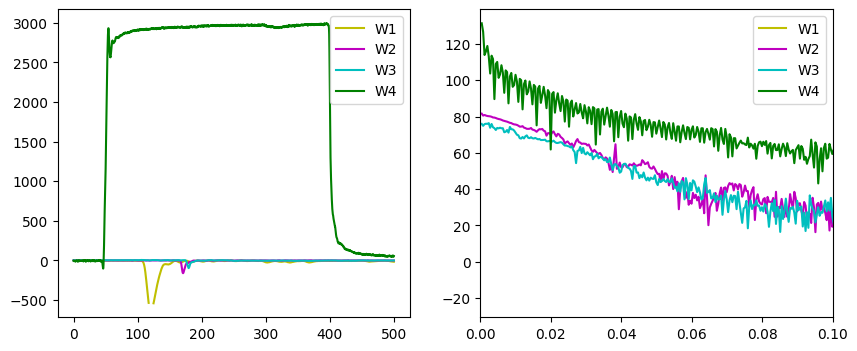

99


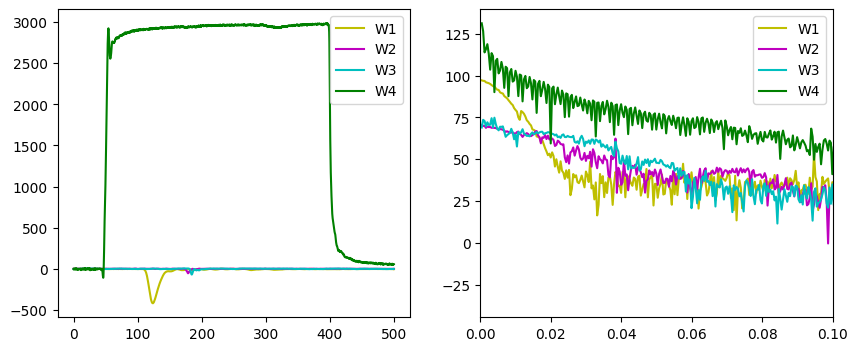

In [ ]:

filename = '/Volumes/WC/data/run_00003.h5.gz'
data = read_hdf5_gz(filename)

WN = ['W1', 'W2', 'W3', 'W4', 'W5', 'W6', 'W7', 'W8']
ch2read = [1, 1 , 1, 1, 0 , 0, 0, 0]
col  = ('y-', 'm-', 'c-', 'g-', 'k-', 'b-', 'r-')
from matplotlib import pyplot as plt
import numpy as np
for event in range(len(data)):
    sevent = str(event)
    print (sevent)
    fig, ax = plt.subplots(1,2, figsize=(10,4))
    wavedesc = json.loads(data[sevent]["H1"])
    for w in range(wavedesc['SUBARRAY_COUNT']):
        for i, val in enumerate(ch2read):
            if val:
                x = np.array(json.loads(data[sevent][WN[i]])[w]['Time (s)'])*1e9
                y = np.array(json.loads(data[sevent][WN[i]])[w]['Amplitude (V)'])/1e-3
                if len(y)>0:
                    time_fft(x,y,col[i],label=WN[i])
    plt.show()

In [ ]:
filename = '/Volumes/WC/data/run_00010.h5.gz'
#data = read_hdf5_gz(filename)

def Gauss3(x, a0, x0, s0):
    import numpy as np
    return a0 * np.exp(-(x - x0)**2 / (2 * s0**2))
def Gauss4(x, a0, x0, s0, d0):
    import numpy as np
    return a0 * np.exp(-(x - x0)**2 / (2 * s0**2))+d0

def fittalo(func, x, y, p0, ax, fmt='k'):
    from scipy.optimize import curve_fit
    from sklearn.metrics import r2_score
    popt, pcov = curve_fit(func,x, y, p0=p0)
    perr = np.sqrt(np.diag(pcov))
    r2=r2_score(y, func(x, *popt))
    xf = np.linspace(x.min(), x.max(), 100)
    if not ax=='':
        ax.plot(xf, func(xf, *popt), fmt, label='a = {0:.2e}±{1:.2e}\nb = {2:.2e}±{3:.2e} \
        \nc = {4:.2e}±{5:.2e}\nr^2 = {6:.3f}'.format(popt[0], perr[0], popt[1], perr[1], popt[2], perr[2], r2))
    return ax, popt

def time_fit(x,y):
    _, par = fittalo(Gauss4,x,y, [y.min(),x[y.argmin()], 10, y[0:80].mean()], ax='', fmt='k--')
    xmin = int(par[1]-3*par[2])
    xmax = int(par[1]+7*par[2])
    return par, np.trapz(y[xmin:xmax], x[xmin:xmax]), xmin


data2save={}
WN = ['W1', 'W2', 'W3', 'W4', 'W5', 'W6', 'W7', 'W8']
ch2read = [1, 1 , 1, 0, 0 , 0, 0, 0]
col  = ('y-', 'm-', 'c-', 'g-', 'k-', 'b-', 'r-')
event=0
iwhen = 10
makeplot = False

df = pd.DataFrame()

with gzip.open(filename, 'rb') as f:
    print('file open')
    # Aprire il file HDF5 decompresso
    with h5py.File(f, 'r') as hdf_file:
        print('file open H5')

        # Iterate over the groups in the HDF5 file
        for group_name in hdf_file:
            data_event = {}
            group = hdf_file[group_name]
            group_data = {}
            # Iterate over the datasets in each group
            for dataset_name in group:
                dataset = group[dataset_name]
                # Check if the dataset is scalar
                # print(dataset)
                if isinstance(dataset, h5py.Dataset) and dataset.shape == ():
                    # Read the value from the scalar dataset
                    group_data[dataset_name] = dataset[()]
                else:
                    # For non-scalar datasets, read the entire dataset
                    group_data[dataset_name] = dataset[:]
            # Add group data to the main data dictionary
            data_event[group_name] = group_data
            if event % iwhen == 0:
                if makeplot:
                    fig, ax = plt.subplots(1,2, figsize=(10,4))
            data2save['id']=group_name

            wavedesc = json.loads(data_event[group_name]["H1"])
            for w in range(wavedesc['SUBARRAY_COUNT']):
                for i, val in enumerate(ch2read):
                    if val:
                        x = np.array(json.loads(data_event[group_name][WN[i]])[w]['Time (s)'])*1e9
                        y = np.array(json.loads(data_event[group_name][WN[i]])[w]['Amplitude (V)'])/1e-3
                        try:
                            par, integ, t0 = time_fit(x,y)
                        except:
                            par = [np.nan,np.nan,np.nan]
                            integ = np.nan
                            t0 = np.nan
                        data2save[str(WN[i])+"_"+str(w)+'_min']=par[1]
                        data2save[str(WN[i])+"_"+str(w)+'_int']=integ
                        data2save[str(WN[i])+"_"+str(w)+'_t0']=t0
                        if event % iwhen == 0:
                            if makeplot:
                                time_fft(x,y,col[i],label=WN[i]+" ev #: "+group_name)
            if event % iwhen == 0:
                print(data2save)
                if makeplot:
                    plt.show()

            df_dictionary = pd.DataFrame([data2save])
            df = pd.concat([df, df_dictionary], ignore_index=True)

            event+=1

file open
file open H5
{'id': '0', 'W1_0_min': 125.73071335692369, 'W1_0_int': -18.755154096449303, 'W1_0_t0': 105, 'W2_0_min': 176.84689975045217, 'W2_0_int': -0.7579598165210805, 'W2_0_t0': 172, 'W3_0_min': 190.630809673893, 'W3_0_int': 7.13436160611565, 'W3_0_t0': 164}
{'id': '107', 'W1_0_min': nan, 'W1_0_int': nan, 'W1_0_t0': nan, 'W2_0_min': 171.6717844039364, 'W2_0_int': -0.8628743269282878, 'W2_0_t0': 162, 'W3_0_min': 178.17893788470766, 'W3_0_int': 2.49735791625094, 'W3_0_t0': 170}
{'id': '116', 'W1_0_min': 123.87646499056264, 'W1_0_int': -18.663775698846845, 'W1_0_t0': 103, 'W2_0_min': 173.95910330664373, 'W2_0_int': -3.010630562581556, 'W2_0_t0': 134, 'W3_0_min': 180.85565953671178, 'W3_0_int': 0.004442175227460557, 'W3_0_t0': 174}
{'id': '125', 'W1_0_min': 122.69864196779403, 'W1_0_int': -21.28298196492809, 'W1_0_t0': 103, 'W2_0_min': 174.23310771935238, 'W2_0_int': -2.262546131795989, 'W2_0_t0': 165, 'W3_0_min': 248.70645809565423, 'W3_0_int': 16.927976779132788, 'W3_0_t0':

/var/folders/rs/2ycf2p992033b5fybp3060w00000gn/T/ipykernel_79444/1033010835.py:14: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func,x, y, p0=p0)


{'id': '134', 'W1_0_min': 124.05632494995217, 'W1_0_int': -20.549214793039567, 'W1_0_t0': 104, 'W2_0_min': 131.42537787122768, 'W2_0_int': -1.210159879419928, 'W2_0_t0': 128, 'W3_0_min': 181.33867075245095, 'W3_0_int': 0.0, 'W3_0_t0': 186}
{'id': '143', 'W1_0_min': nan, 'W1_0_int': nan, 'W1_0_t0': nan, 'W2_0_min': 174.83820752710767, 'W2_0_int': -0.35772685760225587, 'W2_0_t0': 169, 'W3_0_min': 180.36116557235502, 'W3_0_int': 0.24084749949056852, 'W3_0_t0': 172}
{'id': '152', 'W1_0_min': nan, 'W1_0_int': nan, 'W1_0_t0': nan, 'W2_0_min': 177.48143306974612, 'W2_0_int': -2.0159015298018352, 'W2_0_t0': 170, 'W3_0_min': 184.3628774226446, 'W3_0_int': 0.34151787991822957, 'W3_0_t0': 172}
{'id': '161', 'W1_0_min': nan, 'W1_0_int': nan, 'W1_0_t0': nan, 'W2_0_min': 178.48892518098495, 'W2_0_int': 0.2913865058895406, 'W2_0_t0': 172, 'W3_0_min': 182.0387757175567, 'W3_0_int': -10.179252604718371, 'W3_0_t0': 170}
{'id': '170', 'W1_0_min': 125.41659017246907, 'W1_0_int': -21.36397247074845, 'W1_0_

{'id': '459', 'W1_0_min': 125.93312737867177, 'W1_0_int': -19.664155635356, 'W1_0_t0': 104, 'W2_0_min': 177.33035986223817, 'W2_0_int': -2.902514257592945, 'W2_0_t0': 172, 'W3_0_min': 184.7448071751977, 'W3_0_int': -1.053226964915147, 'W3_0_t0': 179}
{'id': '468', 'W1_0_min': 122.88072606791555, 'W1_0_int': -22.7612806180667, 'W1_0_t0': 101, 'W2_0_min': 177.07485477115785, 'W2_0_int': -1.2377753451761322, 'W2_0_t0': 172, 'W3_0_min': 179.88468998974793, 'W3_0_int': 5.263267087539178, 'W3_0_t0': 171}
{'id': '477', 'W1_0_min': 122.0393531620823, 'W1_0_int': -17.717182012383272, 'W1_0_t0': 102, 'W2_0_min': 172.8786415971808, 'W2_0_int': -0.7797638693291227, 'W2_0_t0': 150, 'W3_0_min': 178.93554730939937, 'W3_0_int': -1.099565986229835, 'W3_0_t0': 173}
{'id': '486', 'W1_0_min': 126.30353264000475, 'W1_0_int': -21.971659655578296, 'W1_0_t0': 104, 'W2_0_min': 179.00384683223254, 'W2_0_int': -5.6170806996161, 'W2_0_t0': 157, 'W3_0_min': 184.69990005115656, 'W3_0_int': 0.0, 'W3_0_t0': 188}
{'id

KeyboardInterrupt: 

In [ ]:
df

id    W1_0_min   W1_0_int  W1_0_t0    W2_0_min   W2_0_int  W2_0_t0  \
0      0  125.730713 -18.755154    105.0  176.846900  -0.757960      172   
1      1  125.172911 -20.869463    104.0  178.993038  -0.411023      168   
2     10         NaN        NaN      NaN  185.784107  -0.192108      180   
3    100  123.206395 -19.091346    103.0  195.200038  -3.019610      168   
4    101  123.323009 -24.736106    100.0  174.968344   1.813369       18   
..   ...         ...        ...      ...         ...        ...      ...   
110  198  121.587681 -19.883707    102.0  348.434764 -39.101688      219   
111  199  124.569748 -19.009060    104.0  105.556658  -0.861545      101   
112    2         NaN        NaN      NaN  175.652716   1.057386      169   
113   20  124.235588 -16.320697    104.0  131.476437  -1.418774      128   
114  200         NaN        NaN      NaN  172.031802  -3.144735      164   

       W3_0_min  W3_0_int  W3_0_t0  
0    190.630810  7.134362      164  
1    187.849549  4.298434      182  
2    177.695109 -3.232358      172  
3    178.720129  0.000000      182  
4    183.427161  7.240003      166  
..          ...       ...      ...  
110  178.525145  0.000000      182  
111  182.142086 -1.129179      174  
112  181.338007 -8.762840      169  
113  180.051653  0.000000      184  
114  180.754171 -9.616951      166  

[115 rows x 10 columns]

77
30
30


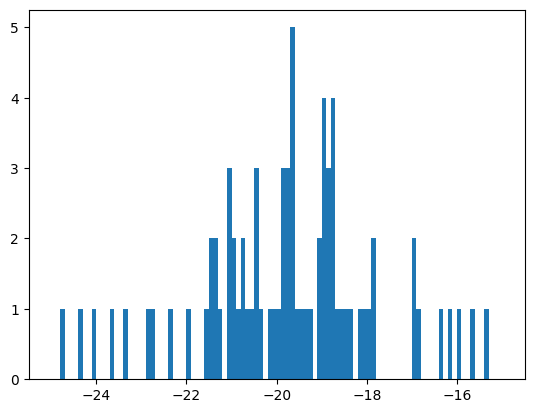

In [ ]:
plt.hist(df.W1_0_int, 100, range=(-25, -15))
#plt.hist(df.W2_0_int[(df.W2_0_int>-25)], 100)
# plt.hist(df.W2_0_int[(df.W2_0_int>-25) & (df.W2_0_int<-2)], 100)
# plt.hist(df.W3_0_int[(df.W3_0_int>-25) & (df.W3_0_int<-2)], 100)
print(len(df.W1_0_int[(df.W1_0_int>-30) & (df.W1_0_int<-15)]))
print(len(df.W3_0_int[(df.W3_0_int>-25) & (df.W3_0_int<-2)]))
print(len(df.W3_0_int[(df.W3_0_int>-25) & (df.W3_0_int<-2)]))
plt.show()

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (2,) + inhomogeneous part.

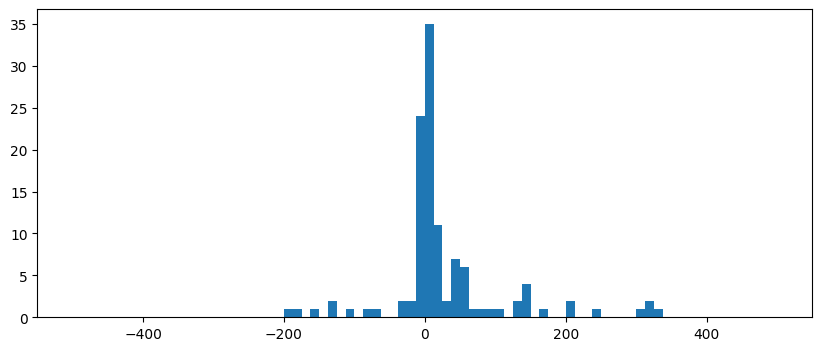

In [ ]:
fig, ax = plt.subplots(1, figsize=(10,4))
ax.hist(df.W3_0_t0-df.W2_0_t0, bins=80, range=(-500, 500))
y=np.histogram(df.W3_0_t0-df.W2_0_t0, bins=80, range=(-500, 500))
x=np.linspace(-500, 500, 80)
ax, par = fittalo(Gauss4,x,y, [10, 0, 10, 0], ax, fmt='k--')
plt.show()

Data read from pickle file:
records:  10


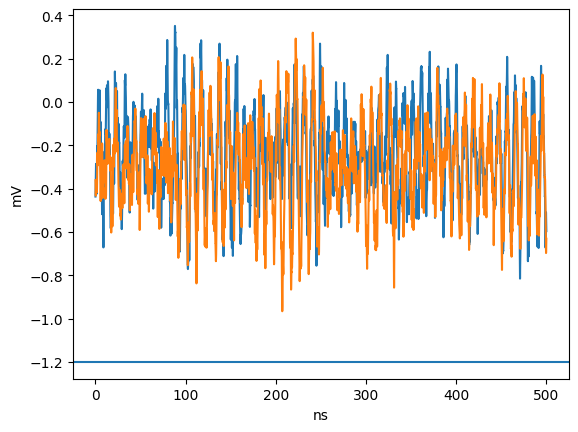

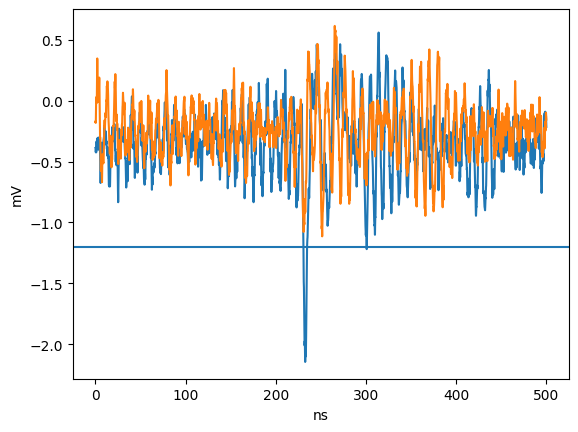

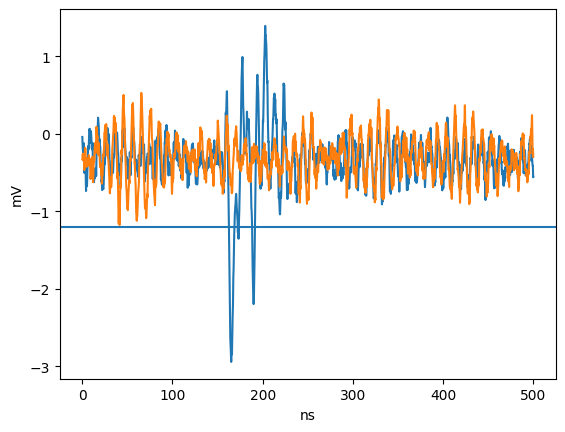

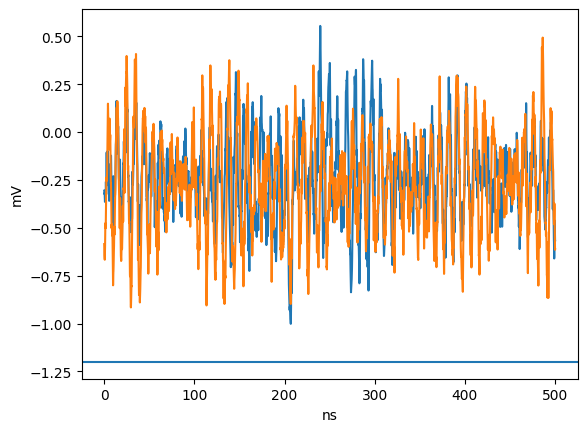

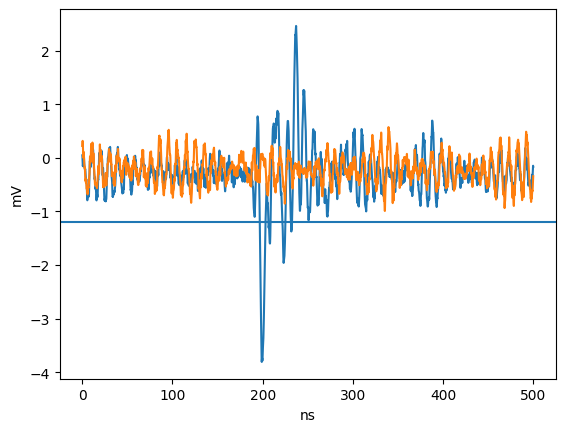

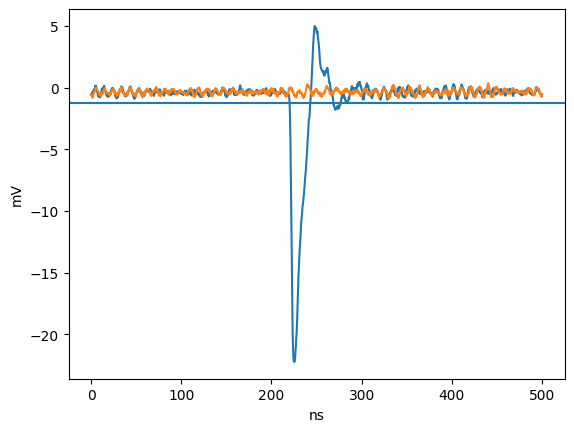

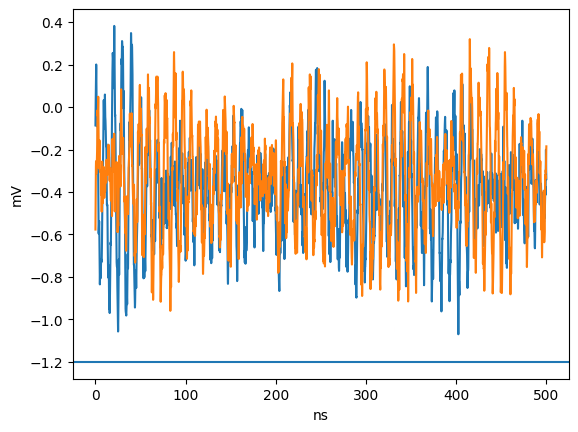

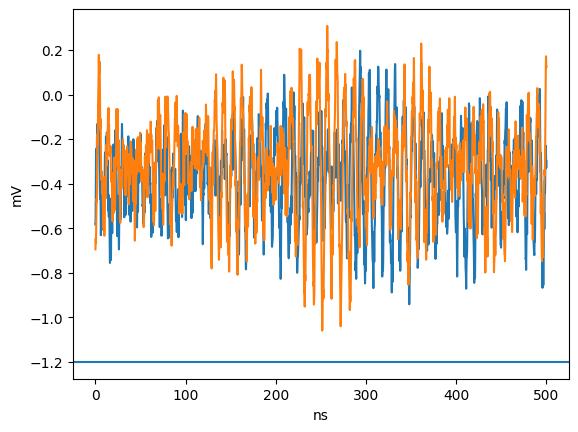

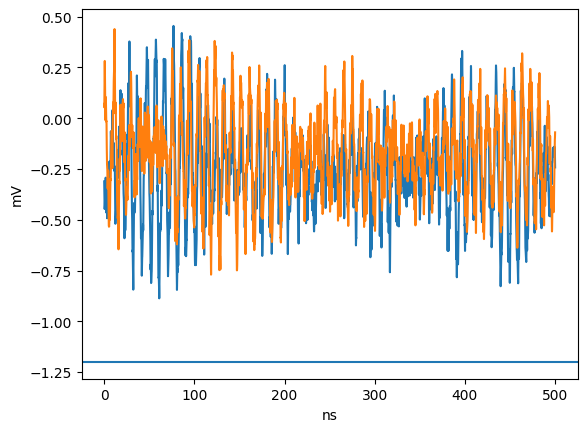

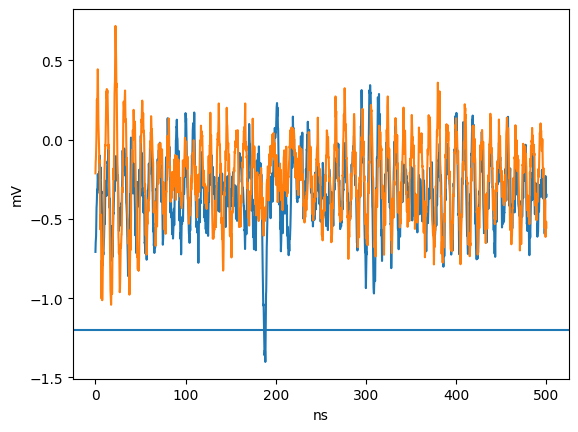

0.0 0.5


In [ ]:
# Example of usage
PATH = '/Volumes/WC/data/'
filename = 'run_00006.pkl'
filepath = PATH+filename
events = read_pickle_file(filepath)
th = -1.2
iand=0
ior=0
mth = [0,0]
plot = True
if data is not None:
    print("Data read from pickle file:")
    print('records: ', len(events))
    ind=0
    for i, event in enumerate(events):
        for j, channel in enumerate(event):
            for k, trigger in enumerate(channel['waveforms']):
                if j<2:
                    x = trigger['Time (s)']*1e9
                    y = trigger['Amplitude (V)']/1e-3
                    mth[j]=np.min(y)
                    if plot:
                        plt.plot(x,y)
        if (mth[0]<th) and (mth[1]<th):
            iand+=1
        if (mth[0]<th) or (mth[1]<th):
            ior+=1
        if plot:
            plt.xlabel('ns')
            plt.ylabel('mV')
            plt.axhline(th)
            plt.show()
print (iand/len(events), ior/len(events))

In [ ]:
def get_s3_sts(client_id, client_secret, endpoint_url, session_token):
    # Specify the session token, access key, and secret key received from the STS
    import boto3
    sts_client = boto3.client('sts',
            endpoint_url = endpoint_url,
            region_name  = ''
            )

    response_sts = sts_client.assume_role_with_web_identity(
            RoleArn          = "arn:aws:iam:::role/S3AccessIAM200",
            RoleSessionName  = 'cygno',
            DurationSeconds  = 3600,
            WebIdentityToken = session_token # qua ci va il token IAM
            )

    s3 = boto3.client('s3',
            aws_access_key_id     = response_sts['Credentials']['AccessKeyId'],
            aws_secret_access_key = response_sts['Credentials']['SecretAccessKey'],
            aws_session_token     = response_sts['Credentials']['SessionToken'],
            endpoint_url          = endpoint_url,
            region_name           = '')
    return s3

def upload_file_2_S3(file_name, client_id, client_secret,  endpoint_url, bucket, tag, tfile, verbose=False):

    with open(tfile) as file:
        token = file.readline().strip('\n')
    session_token= token
    if (verbose): print("TOKEN > ",tfile, token)
    s3 = get_s3_sts(client_id, client_secret, endpoint_url, session_token)
    filename = file_name.split('/')[-1]
    try:
        s3.upload_file(file_name, Bucket=bucket, Key=tag+'/'+filename)
        return 0
    except Exception as e:
        print('ERROR S3 file update: {:s} --> '.format(file_name), e)
        return 1


In [ ]:
upload_file_2_S3(filename, os.environ['IAM_CLIENT_ID'], os.environ['IAM_CLIENT_SECRET'],
                 'https://minio.cloud.infn.it/', 'cygno-analysis', 'WC', '/tmp/token', verbose=False)

0

In [ ]:
def Gauss3(x, a0, x0, s0):
    import numpy as np
    return a0 * np.exp(-(x - x0)**2 / (2 * s0**2))
def Gauss4(x, a0, x0, s0, d0):
    import numpy as np
    return a0 * np.exp(-(x - x0)**2 / (2 * s0**2))+d0

# def fittalo(func, x, y, ax, p0, fmt='k'):
#     from scipy.optimize import curve_fit
#     from sklearn.metrics import r2_score
#     popt, pcov = curve_fit(func,x, y, p0=p0)
#     perr = np.sqrt(np.diag(pcov))
#     r2=r2_score(y, func(x, *popt))
#     xf = np.linspace(x.min(), x.max(), 100)
#     ax.plot(xf, func(xf, *popt), fmt, label='a = {0:.2e}±{1:.2e}\nb = {2:.2e}±{3:.2e} \
#     \nc = {4:.2e}±{5:.2e}\nr^2 = {6:.3f}'.format(popt[0], perr[0], popt[1], perr[1], popt[2], perr[2], r2))
#     return ax, popt

def fittalo(func, x, y, p0, ax, fmt='k'):
    from scipy.optimize import curve_fit
    from sklearn.metrics import r2_score
    popt, pcov = curve_fit(func,x, y, p0=p0)
    perr = np.sqrt(np.diag(pcov))
    r2=r2_score(y, func(x, *popt))
    xf = np.linspace(x.min(), x.max(), 100)
    if not ax=='':
        ax.plot(xf, func(xf, *popt), fmt, label='a = {0:.2e}±{1:.2e}\nb = {2:.2e}±{3:.2e} \
        \nc = {4:.2e}±{5:.2e}\nr^2 = {6:.3f}'.format(popt[0], perr[0], popt[1], perr[1], popt[2], perr[2], r2))
    return ax, popt

event = 8
i = 1
x = np.array(json.loads(data[str(event)]["W"+str(i)])[w]['Time (s)'])*1e9
y = np.array(json.loads(data[str(event)]["W"+str(i)])[w]['Amplitude (V)'])/1e-3
def time_fit(x,y):
    _, par = fittalo(Gauss4,x,y, [y.min(),x[y.argmin()], 10, y[0:80].mean()], ax='', fmt='k--')
    xmin = int(par[1]-3*par[2])
    xmax = int(par[1]+7*par[2])
    return par, np.trapz(y[xmin:xmax], x[xmin:xmax]), xmin
time_fit(x,y)

ValueError: array must not contain infs or NaNs

In [ ]:
from scipy import signal
sig = np.repeat([0., 1., 1., 0., 1., 0., 0., 1.], 128)
sig_noise = sig + np.random.randn(len(sig))
corr = signal.correlate(sig_noise, np.ones(128), mode='same') / 128

/var/folders/rs/2ycf2p992033b5fybp3060w00000gn/T/ipykernel_94791/76683225.py:15: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


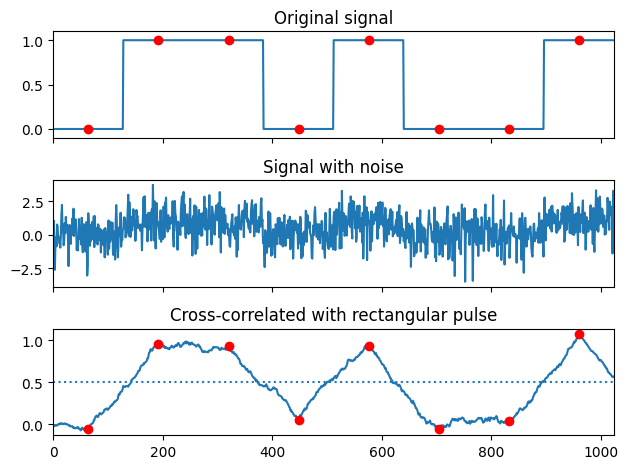

In [ ]:
import matplotlib.pyplot as plt
clock = np.arange(64, len(sig), 128)
fig, (ax_orig, ax_noise, ax_corr) = plt.subplots(3, 1, sharex=True)
ax_orig.plot(sig)
ax_orig.plot(clock, sig[clock], 'ro')
ax_orig.set_title('Original signal')
ax_noise.plot(sig_noise)
ax_noise.set_title('Signal with noise')
ax_corr.plot(corr)
ax_corr.plot(clock, corr[clock], 'ro')
ax_corr.axhline(0.5, ls=':')
ax_corr.set_title('Cross-correlated with rectangular pulse')
ax_orig.margins(0, 0.1)
fig.tight_layout()
fig.show()

In [ ]:
def ExpFD(x, p0, p1, p2, p3): # negative exponential + fermi dirac rise
    # (1/(1+exp(([0]-x)/[1])))*(-[2]*exp(-x/[3])) # Natalia/Pinci
    import numpy as np
    return (1/(1+np.exp((p0-x)/p1)))*(-p2*np.exp(-x/p3))

def GExp(x, p0, p1, p2, p3, p4): # Gauss + expnential tail
    import numpy as np
    return p0*(np.exp(-(x - p1)**2 / (2 * p2**2)) + p3*(-np.exp(-x/p4)))


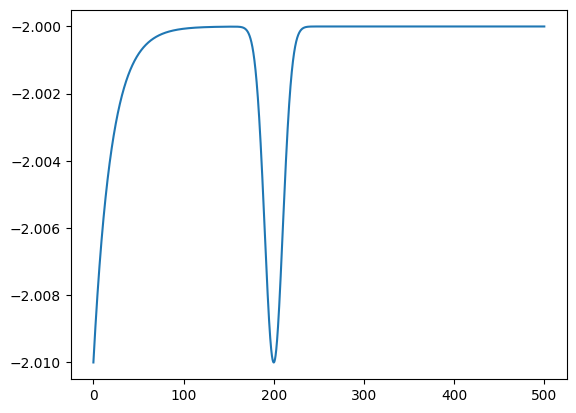

In [ ]:
plt.plot(x, GExp(x, -0.01, 200, 10, -1, 20))
plt.show()

In [ ]:
# test append online
import boto3
import h5py
import io

def append_record_to_hdf5_s3(bucket_name, key, record, access_key_id, secret_access_key, session_token):
    # Connect to S3 using boto3
    endpoint_url='https://minio.cloud.infn.it/'
    version='s3v4'
    s3 = get_s3_sts(access_key_id, secret_access_key, endpoint_url, session_token)
    try:
        # Read the existing HDF5 file from S3
        response = s3.get_object(Bucket=bucket_name, Key=key)
        hdf5_bytes = response['Body'].read()
    except s3.exceptions.NoSuchKey:
        # If the file does not exist, create a new HDF5 file
        hdf5_bytes = bytearray()

    # Open the HDF5 file in memory
    with io.BytesIO(hdf5_bytes) as hdf5_buffer:
        with h5py.File(hdf5_buffer, 'a') as hdf_file:
            # Create a group for each record, where the group name is based on the record ID
            group_name = f"record_{record['Id']}"
            group = hdf_file.create_group(group_name)

            # Add dataset(s) within the group to store the record data
            for key, value in record.items():
                if isinstance(value, dict):
                    # If the value is a nested dictionary, create a subgroup
                    sub_group = group.create_group(key)
                    for sub_key, sub_value in value.items():
                        sub_group.create_dataset(sub_key, data=sub_value)
                else:
                    # Otherwise, create a dataset directly
                    group.create_dataset(key, data=value)

    # Write the updated HDF5 file back to S3
    s3.put_object(Bucket=bucket_name, Key=key, Body=hdf5_buffer.getvalue())

def append_record_to_hdf5_s3(bucket_name, key, record, access_key_id, secret_access_key, session_token):
    # Connect to S3 using boto3
    endpoint_url = 'https://minio.cloud.infn.it/'
    version = 's3v4'
    s3 = get_s3_sts(access_key_id, secret_access_key, endpoint_url, session_token)
    try:
        # Read the existing HDF5 file from S3
        response = s3.get_object(Bucket=bucket_name, Key=key)
        hdf5_bytes = response['Body'].read()
    except s3.exceptions.NoSuchKey:
        # If the file does not exist, create a new HDF5 file
        hdf5_bytes = bytearray()

    # Open the HDF5 file in memory
    with io.BytesIO(hdf5_bytes) as hdf5_buffer:
        with h5py.File(hdf5_buffer, 'a') as hdf_file:
            # Create a group for each record, where the group name is based on the record ID
            group_name = f"record_{record['Id']}"
            group = hdf_file.create_group(group_name)

            # Add dataset(s) within the group to store the record data
            for key, value in record.items():
                if isinstance(value, dict):
                    # If the value is a nested dictionary, create a subgroup
                    sub_group = group.create_group(key)
                    for sub_key, sub_value in value.items():
                        sub_group.create_dataset(sub_key, data=sub_value)
                else:
                    # Otherwise, create a dataset directly
                    group.create_dataset(key, data=value)

        # Write the updated HDF5 file back to S3
        print (hdf5_buffer.getvalue())
        s3.put_object(Bucket=bucket_name, Key=key, Body=hdf5_buffer.getvalue())